In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

In [2]:
batchSize = 64
imageSize = 64

In [4]:
transform = transforms.Compose([transforms.Resize(imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])

In [5]:
dataset = dset.CIFAR10(root='./datasets', download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=2)

Files already downloaded and verified


In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [18]:
class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, input):
        output = self.main(input)
        return output
    
netG = G()
netG.cuda()
netG.apply(weights_init)

G(
  (main): Sequential(
    (0): ConvTranspose2d (100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d (512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d (256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d (128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d (64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [19]:
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        output = self.main(input)
        return output.view(-1)
    
netD = D()
netD.cuda()
netD.apply(weights_init)

D(
  (main): Sequential(
    (0): Conv2d (3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(0.2, inplace)
    (2): Conv2d (64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU(0.2, inplace)
    (5): Conv2d (128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU(0.2, inplace)
    (8): Conv2d (256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (10): LeakyReLU(0.2, inplace)
    (11): Conv2d (512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [20]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [21]:
for epoch in range(25):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real, _ = data
        inp = Variable(real.cuda())
        target = Variable(torch.ones(inp.size()[0]).cuda())
        output = netD(inp)
        errD_real = criterion(output, target)
        
        noise = Variable(torch.randn(inp.size()[0], 100, 1, 1).cuda())
        fake = netG(noise)
        target = Variable(torch.zeros(inp.size()[0]).cuda())
        output = netD(fake.detach())
        errD_fake = criterion(output, target)
        
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()
        
        netG.zero_grad()
        target = Variable(torch.ones(inp.size()[0]).cuda())
        output = netD(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step()
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch, 25, i, len(dataloader), errD.data[0], errG.data[0]))
        if i % 100 == 0:
            vutils.save_image(real, '%s/real_samples.png' % "./datasets", normalize = True)
            fake = netG(noise)
            vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./datasets", epoch), normalize = True)

[0/25][0/782] Loss_D: 1.9185 Loss_G: 5.3691
[0/25][1/782] Loss_D: 1.0436 Loss_G: 5.6243
[0/25][2/782] Loss_D: 0.8934 Loss_G: 5.8135
[0/25][3/782] Loss_D: 0.9080 Loss_G: 6.9211
[0/25][4/782] Loss_D: 0.9030 Loss_G: 6.3584
[0/25][5/782] Loss_D: 0.8756 Loss_G: 7.6405
[0/25][6/782] Loss_D: 0.5310 Loss_G: 8.1110
[0/25][7/782] Loss_D: 0.5428 Loss_G: 7.9066
[0/25][8/782] Loss_D: 0.5585 Loss_G: 8.4223
[0/25][9/782] Loss_D: 0.4506 Loss_G: 7.7163
[0/25][10/782] Loss_D: 0.5968 Loss_G: 10.6845
[0/25][11/782] Loss_D: 0.2429 Loss_G: 8.2576
[0/25][12/782] Loss_D: 0.5415 Loss_G: 10.6777
[0/25][13/782] Loss_D: 0.6650 Loss_G: 8.5520
[0/25][14/782] Loss_D: 0.7661 Loss_G: 12.8065
[0/25][15/782] Loss_D: 0.2847 Loss_G: 9.5538
[0/25][16/782] Loss_D: 0.8124 Loss_G: 13.9290
[0/25][17/782] Loss_D: 0.2160 Loss_G: 10.9467
[0/25][18/782] Loss_D: 0.3480 Loss_G: 9.8877
[0/25][19/782] Loss_D: 0.6336 Loss_G: 16.0647
[0/25][20/782] Loss_D: 0.2437 Loss_G: 13.6815
[0/25][21/782] Loss_D: 0.2623 Loss_G: 6.6725
[0/25][22/782

[0/25][180/782] Loss_D: 0.2970 Loss_G: 4.9499
[0/25][181/782] Loss_D: 0.2917 Loss_G: 5.7675
[0/25][182/782] Loss_D: 0.4398 Loss_G: 3.9476
[0/25][183/782] Loss_D: 0.4316 Loss_G: 7.2151
[0/25][184/782] Loss_D: 0.1860 Loss_G: 6.4054
[0/25][185/782] Loss_D: 0.3341 Loss_G: 3.4503
[0/25][186/782] Loss_D: 0.6612 Loss_G: 8.9746
[0/25][187/782] Loss_D: 0.4134 Loss_G: 7.8204
[0/25][188/782] Loss_D: 0.1658 Loss_G: 5.0346
[0/25][189/782] Loss_D: 0.2601 Loss_G: 5.1989
[0/25][190/782] Loss_D: 0.2717 Loss_G: 7.0709
[0/25][191/782] Loss_D: 0.1168 Loss_G: 6.4041
[0/25][192/782] Loss_D: 0.1683 Loss_G: 4.8415
[0/25][193/782] Loss_D: 0.3702 Loss_G: 6.3766
[0/25][194/782] Loss_D: 0.3583 Loss_G: 4.6985
[0/25][195/782] Loss_D: 0.3187 Loss_G: 7.3933
[0/25][196/782] Loss_D: 0.1999 Loss_G: 6.5242
[0/25][197/782] Loss_D: 0.1093 Loss_G: 5.0196
[0/25][198/782] Loss_D: 0.2422 Loss_G: 5.9928
[0/25][199/782] Loss_D: 0.1855 Loss_G: 5.8678
[0/25][200/782] Loss_D: 0.2539 Loss_G: 5.7448
[0/25][201/782] Loss_D: 0.2486 Los

[0/25][358/782] Loss_D: 0.2545 Loss_G: 4.4920
[0/25][359/782] Loss_D: 0.3300 Loss_G: 4.9700
[0/25][360/782] Loss_D: 0.0781 Loss_G: 5.3418
[0/25][361/782] Loss_D: 0.2552 Loss_G: 3.9374
[0/25][362/782] Loss_D: 0.3435 Loss_G: 5.3956
[0/25][363/782] Loss_D: 0.3450 Loss_G: 3.8943
[0/25][364/782] Loss_D: 0.3252 Loss_G: 5.2655
[0/25][365/782] Loss_D: 0.3920 Loss_G: 3.5726
[0/25][366/782] Loss_D: 0.3089 Loss_G: 4.5975
[0/25][367/782] Loss_D: 0.3717 Loss_G: 5.2778
[0/25][368/782] Loss_D: 0.6581 Loss_G: 0.7081
[0/25][369/782] Loss_D: 2.1708 Loss_G: 13.5572
[0/25][370/782] Loss_D: 5.0483 Loss_G: 5.3985
[0/25][371/782] Loss_D: 0.3433 Loss_G: 1.5205
[0/25][372/782] Loss_D: 1.0111 Loss_G: 6.9243
[0/25][373/782] Loss_D: 0.8002 Loss_G: 4.7091
[0/25][374/782] Loss_D: 0.2801 Loss_G: 3.4194
[0/25][375/782] Loss_D: 0.8866 Loss_G: 5.3421
[0/25][376/782] Loss_D: 0.3333 Loss_G: 4.8644
[0/25][377/782] Loss_D: 0.7121 Loss_G: 1.6221
[0/25][378/782] Loss_D: 1.2638 Loss_G: 6.6719
[0/25][379/782] Loss_D: 0.8083 Lo

[0/25][536/782] Loss_D: 0.4435 Loss_G: 5.4736
[0/25][537/782] Loss_D: 0.5454 Loss_G: 4.7562
[0/25][538/782] Loss_D: 0.9121 Loss_G: 7.3729
[0/25][539/782] Loss_D: 0.3613 Loss_G: 5.4619
[0/25][540/782] Loss_D: 0.2259 Loss_G: 4.2818
[0/25][541/782] Loss_D: 0.8334 Loss_G: 9.4898
[0/25][542/782] Loss_D: 0.5650 Loss_G: 5.5063
[0/25][543/782] Loss_D: 0.5359 Loss_G: 1.6902
[0/25][544/782] Loss_D: 1.2824 Loss_G: 8.8008
[0/25][545/782] Loss_D: 0.6918 Loss_G: 6.8359
[0/25][546/782] Loss_D: 0.8880 Loss_G: 1.6477
[0/25][547/782] Loss_D: 1.6811 Loss_G: 8.1484
[0/25][548/782] Loss_D: 0.7836 Loss_G: 6.1355
[0/25][549/782] Loss_D: 0.3753 Loss_G: 3.4831
[0/25][550/782] Loss_D: 0.4194 Loss_G: 4.6042
[0/25][551/782] Loss_D: 0.7786 Loss_G: 5.9930
[0/25][552/782] Loss_D: 0.5138 Loss_G: 3.9069
[0/25][553/782] Loss_D: 0.2736 Loss_G: 3.7740
[0/25][554/782] Loss_D: 0.6053 Loss_G: 5.9273
[0/25][555/782] Loss_D: 0.3380 Loss_G: 4.6060
[0/25][556/782] Loss_D: 0.4070 Loss_G: 3.1001
[0/25][557/782] Loss_D: 0.2927 Los

[0/25][715/782] Loss_D: 0.6990 Loss_G: 0.9410
[0/25][716/782] Loss_D: 2.0246 Loss_G: 8.3726
[0/25][717/782] Loss_D: 2.1417 Loss_G: 0.3148
[0/25][718/782] Loss_D: 2.3185 Loss_G: 5.4935
[0/25][719/782] Loss_D: 1.5258 Loss_G: 2.2373
[0/25][720/782] Loss_D: 0.7495 Loss_G: 2.9056
[0/25][721/782] Loss_D: 0.8982 Loss_G: 3.4341
[0/25][722/782] Loss_D: 0.9007 Loss_G: 2.2475
[0/25][723/782] Loss_D: 0.7505 Loss_G: 3.6771
[0/25][724/782] Loss_D: 0.8259 Loss_G: 2.5607
[0/25][725/782] Loss_D: 0.8914 Loss_G: 3.1640
[0/25][726/782] Loss_D: 0.9241 Loss_G: 2.7011
[0/25][727/782] Loss_D: 0.7927 Loss_G: 3.3952
[0/25][728/782] Loss_D: 0.7009 Loss_G: 2.6048
[0/25][729/782] Loss_D: 0.7596 Loss_G: 3.8545
[0/25][730/782] Loss_D: 0.5918 Loss_G: 2.8597
[0/25][731/782] Loss_D: 0.4927 Loss_G: 3.0851
[0/25][732/782] Loss_D: 0.3942 Loss_G: 3.1816
[0/25][733/782] Loss_D: 0.3944 Loss_G: 3.1446
[0/25][734/782] Loss_D: 0.4346 Loss_G: 3.8230
[0/25][735/782] Loss_D: 0.5839 Loss_G: 1.8545
[0/25][736/782] Loss_D: 1.1888 Los

[1/25][114/782] Loss_D: 0.3287 Loss_G: 2.9218
[1/25][115/782] Loss_D: 0.7382 Loss_G: 5.7282
[1/25][116/782] Loss_D: 0.5147 Loss_G: 3.8112
[1/25][117/782] Loss_D: 0.8640 Loss_G: 3.4038
[1/25][118/782] Loss_D: 0.8321 Loss_G: 5.6854
[1/25][119/782] Loss_D: 1.1786 Loss_G: 1.9743
[1/25][120/782] Loss_D: 1.1790 Loss_G: 7.6580
[1/25][121/782] Loss_D: 1.0043 Loss_G: 3.6580
[1/25][122/782] Loss_D: 0.6593 Loss_G: 1.4455
[1/25][123/782] Loss_D: 1.2024 Loss_G: 7.0227
[1/25][124/782] Loss_D: 0.7149 Loss_G: 3.8762
[1/25][125/782] Loss_D: 0.5443 Loss_G: 2.8889
[1/25][126/782] Loss_D: 0.7401 Loss_G: 5.3154
[1/25][127/782] Loss_D: 0.8278 Loss_G: 2.6490
[1/25][128/782] Loss_D: 0.8996 Loss_G: 3.3013
[1/25][129/782] Loss_D: 0.7892 Loss_G: 4.0429
[1/25][130/782] Loss_D: 0.7029 Loss_G: 2.8548
[1/25][131/782] Loss_D: 0.6629 Loss_G: 3.5412
[1/25][132/782] Loss_D: 1.1310 Loss_G: 1.7873
[1/25][133/782] Loss_D: 0.9042 Loss_G: 5.3044
[1/25][134/782] Loss_D: 0.7791 Loss_G: 2.4519
[1/25][135/782] Loss_D: 1.0986 Los

[1/25][293/782] Loss_D: 1.6103 Loss_G: 2.5012
[1/25][294/782] Loss_D: 1.0367 Loss_G: 6.8685
[1/25][295/782] Loss_D: 0.9012 Loss_G: 2.5376
[1/25][296/782] Loss_D: 0.4258 Loss_G: 3.2665
[1/25][297/782] Loss_D: 0.5343 Loss_G: 5.1295
[1/25][298/782] Loss_D: 0.5509 Loss_G: 2.2539
[1/25][299/782] Loss_D: 0.8026 Loss_G: 5.8709
[1/25][300/782] Loss_D: 0.8054 Loss_G: 2.6521
[1/25][301/782] Loss_D: 0.7918 Loss_G: 4.5066
[1/25][302/782] Loss_D: 0.4546 Loss_G: 4.5779
[1/25][303/782] Loss_D: 0.5159 Loss_G: 3.7600
[1/25][304/782] Loss_D: 0.6943 Loss_G: 5.2948
[1/25][305/782] Loss_D: 1.1048 Loss_G: 1.7276
[1/25][306/782] Loss_D: 1.0116 Loss_G: 6.6366
[1/25][307/782] Loss_D: 0.7839 Loss_G: 3.1475
[1/25][308/782] Loss_D: 0.4582 Loss_G: 4.4187
[1/25][309/782] Loss_D: 0.3057 Loss_G: 4.3761
[1/25][310/782] Loss_D: 0.3639 Loss_G: 3.3137
[1/25][311/782] Loss_D: 0.4049 Loss_G: 4.1138
[1/25][312/782] Loss_D: 0.3474 Loss_G: 3.7460
[1/25][313/782] Loss_D: 0.4396 Loss_G: 3.6081
[1/25][314/782] Loss_D: 0.4917 Los

[1/25][472/782] Loss_D: 0.4987 Loss_G: 4.4906
[1/25][473/782] Loss_D: 0.3827 Loss_G: 4.1497
[1/25][474/782] Loss_D: 0.3202 Loss_G: 3.4326
[1/25][475/782] Loss_D: 0.4731 Loss_G: 4.3573
[1/25][476/782] Loss_D: 0.2489 Loss_G: 4.4429
[1/25][477/782] Loss_D: 0.4193 Loss_G: 3.2867
[1/25][478/782] Loss_D: 0.4526 Loss_G: 3.4570
[1/25][479/782] Loss_D: 0.5578 Loss_G: 2.9924
[1/25][480/782] Loss_D: 0.4010 Loss_G: 4.3245
[1/25][481/782] Loss_D: 0.6483 Loss_G: 2.6725
[1/25][482/782] Loss_D: 0.6756 Loss_G: 3.4895
[1/25][483/782] Loss_D: 0.5781 Loss_G: 3.5950
[1/25][484/782] Loss_D: 0.3975 Loss_G: 3.1319
[1/25][485/782] Loss_D: 0.6885 Loss_G: 4.9064
[1/25][486/782] Loss_D: 0.5607 Loss_G: 3.2797
[1/25][487/782] Loss_D: 0.5285 Loss_G: 4.3034
[1/25][488/782] Loss_D: 0.5344 Loss_G: 3.2697
[1/25][489/782] Loss_D: 0.5992 Loss_G: 4.4807
[1/25][490/782] Loss_D: 0.6926 Loss_G: 2.7666
[1/25][491/782] Loss_D: 0.4214 Loss_G: 4.0827
[1/25][492/782] Loss_D: 0.4722 Loss_G: 4.5526
[1/25][493/782] Loss_D: 0.4048 Los

[1/25][651/782] Loss_D: 1.2208 Loss_G: 2.9345
[1/25][652/782] Loss_D: 0.5874 Loss_G: 3.8064
[1/25][653/782] Loss_D: 0.3889 Loss_G: 4.1208
[1/25][654/782] Loss_D: 0.2507 Loss_G: 3.3864
[1/25][655/782] Loss_D: 0.3248 Loss_G: 3.2770
[1/25][656/782] Loss_D: 0.6027 Loss_G: 3.6245
[1/25][657/782] Loss_D: 0.4901 Loss_G: 3.0530
[1/25][658/782] Loss_D: 0.6521 Loss_G: 4.6494
[1/25][659/782] Loss_D: 0.5173 Loss_G: 2.7710
[1/25][660/782] Loss_D: 0.5774 Loss_G: 3.6542
[1/25][661/782] Loss_D: 0.6670 Loss_G: 3.2395
[1/25][662/782] Loss_D: 1.0331 Loss_G: 3.9614
[1/25][663/782] Loss_D: 0.6637 Loss_G: 2.8521
[1/25][664/782] Loss_D: 0.7125 Loss_G: 4.0407
[1/25][665/782] Loss_D: 0.4163 Loss_G: 3.4222
[1/25][666/782] Loss_D: 0.3839 Loss_G: 2.7351
[1/25][667/782] Loss_D: 0.7097 Loss_G: 5.8348
[1/25][668/782] Loss_D: 1.0124 Loss_G: 1.8243
[1/25][669/782] Loss_D: 0.9250 Loss_G: 6.2051
[1/25][670/782] Loss_D: 1.4134 Loss_G: 1.6951
[1/25][671/782] Loss_D: 0.7156 Loss_G: 4.3048
[1/25][672/782] Loss_D: 0.4438 Los

[2/25][49/782] Loss_D: 0.5095 Loss_G: 2.6508
[2/25][50/782] Loss_D: 0.4971 Loss_G: 3.5448
[2/25][51/782] Loss_D: 0.5059 Loss_G: 3.3064
[2/25][52/782] Loss_D: 0.7142 Loss_G: 3.2073
[2/25][53/782] Loss_D: 0.7570 Loss_G: 0.8866
[2/25][54/782] Loss_D: 1.0907 Loss_G: 5.7225
[2/25][55/782] Loss_D: 0.6295 Loss_G: 2.4609
[2/25][56/782] Loss_D: 0.5477 Loss_G: 3.9797
[2/25][57/782] Loss_D: 0.7340 Loss_G: 1.9038
[2/25][58/782] Loss_D: 0.9544 Loss_G: 4.4744
[2/25][59/782] Loss_D: 0.6438 Loss_G: 2.0669
[2/25][60/782] Loss_D: 0.8822 Loss_G: 4.3434
[2/25][61/782] Loss_D: 1.3495 Loss_G: 0.9606
[2/25][62/782] Loss_D: 1.0532 Loss_G: 5.3738
[2/25][63/782] Loss_D: 0.8623 Loss_G: 1.9178
[2/25][64/782] Loss_D: 1.1739 Loss_G: 4.0776
[2/25][65/782] Loss_D: 0.7448 Loss_G: 2.1525
[2/25][66/782] Loss_D: 1.0464 Loss_G: 5.3436
[2/25][67/782] Loss_D: 0.8605 Loss_G: 1.8972
[2/25][68/782] Loss_D: 0.9648 Loss_G: 4.1408
[2/25][69/782] Loss_D: 0.7360 Loss_G: 1.8455
[2/25][70/782] Loss_D: 0.9422 Loss_G: 4.8974
[2/25][71/

[2/25][229/782] Loss_D: 0.7551 Loss_G: 1.5059
[2/25][230/782] Loss_D: 1.8896 Loss_G: 7.1283
[2/25][231/782] Loss_D: 2.2163 Loss_G: 2.1657
[2/25][232/782] Loss_D: 0.6980 Loss_G: 3.0387
[2/25][233/782] Loss_D: 0.8571 Loss_G: 5.0732
[2/25][234/782] Loss_D: 0.6787 Loss_G: 2.7009
[2/25][235/782] Loss_D: 0.6645 Loss_G: 3.9079
[2/25][236/782] Loss_D: 0.6550 Loss_G: 2.7605
[2/25][237/782] Loss_D: 0.7283 Loss_G: 2.1357
[2/25][238/782] Loss_D: 0.7733 Loss_G: 5.1291
[2/25][239/782] Loss_D: 0.5954 Loss_G: 3.0846
[2/25][240/782] Loss_D: 0.2371 Loss_G: 2.7355
[2/25][241/782] Loss_D: 0.5159 Loss_G: 3.6131
[2/25][242/782] Loss_D: 0.5427 Loss_G: 4.0556
[2/25][243/782] Loss_D: 0.7082 Loss_G: 2.3831
[2/25][244/782] Loss_D: 0.3911 Loss_G: 2.9758
[2/25][245/782] Loss_D: 0.5914 Loss_G: 2.6531
[2/25][246/782] Loss_D: 0.4799 Loss_G: 3.2035
[2/25][247/782] Loss_D: 0.5967 Loss_G: 2.4875
[2/25][248/782] Loss_D: 0.6155 Loss_G: 3.3208
[2/25][249/782] Loss_D: 0.5551 Loss_G: 3.5792
[2/25][250/782] Loss_D: 0.6026 Los

[2/25][408/782] Loss_D: 0.3220 Loss_G: 3.4938
[2/25][409/782] Loss_D: 0.3873 Loss_G: 3.7978
[2/25][410/782] Loss_D: 0.4264 Loss_G: 2.4970
[2/25][411/782] Loss_D: 0.9495 Loss_G: 2.4806
[2/25][412/782] Loss_D: 0.5614 Loss_G: 4.7702
[2/25][413/782] Loss_D: 0.5303 Loss_G: 3.0304
[2/25][414/782] Loss_D: 0.6971 Loss_G: 2.5836
[2/25][415/782] Loss_D: 0.7308 Loss_G: 2.7325
[2/25][416/782] Loss_D: 0.7065 Loss_G: 4.8251
[2/25][417/782] Loss_D: 1.1024 Loss_G: 1.1453
[2/25][418/782] Loss_D: 1.9539 Loss_G: 6.6330
[2/25][419/782] Loss_D: 2.2624 Loss_G: 0.5480
[2/25][420/782] Loss_D: 1.9544 Loss_G: 6.0553
[2/25][421/782] Loss_D: 1.7516 Loss_G: 0.7161
[2/25][422/782] Loss_D: 1.5134 Loss_G: 5.1940
[2/25][423/782] Loss_D: 0.5153 Loss_G: 4.2563
[2/25][424/782] Loss_D: 0.4955 Loss_G: 1.8331
[2/25][425/782] Loss_D: 0.8137 Loss_G: 3.6523
[2/25][426/782] Loss_D: 0.4371 Loss_G: 3.5933
[2/25][427/782] Loss_D: 0.7798 Loss_G: 1.8676
[2/25][428/782] Loss_D: 1.1471 Loss_G: 3.6903
[2/25][429/782] Loss_D: 0.3865 Los

[2/25][587/782] Loss_D: 0.7145 Loss_G: 3.1046
[2/25][588/782] Loss_D: 0.3266 Loss_G: 3.5360
[2/25][589/782] Loss_D: 0.4132 Loss_G: 2.8541
[2/25][590/782] Loss_D: 0.4048 Loss_G: 2.3468
[2/25][591/782] Loss_D: 0.4502 Loss_G: 3.3440
[2/25][592/782] Loss_D: 0.3860 Loss_G: 2.9122
[2/25][593/782] Loss_D: 0.7520 Loss_G: 1.5955
[2/25][594/782] Loss_D: 0.4803 Loss_G: 4.8042
[2/25][595/782] Loss_D: 1.1385 Loss_G: 0.1919
[2/25][596/782] Loss_D: 2.8269 Loss_G: 7.7393
[2/25][597/782] Loss_D: 2.5716 Loss_G: 0.0598
[2/25][598/782] Loss_D: 3.5033 Loss_G: 4.7305
[2/25][599/782] Loss_D: 2.3326 Loss_G: 1.1261
[2/25][600/782] Loss_D: 1.0539 Loss_G: 2.4063
[2/25][601/782] Loss_D: 1.2398 Loss_G: 0.9717
[2/25][602/782] Loss_D: 1.2356 Loss_G: 2.5449
[2/25][603/782] Loss_D: 0.7508 Loss_G: 3.1150
[2/25][604/782] Loss_D: 1.1706 Loss_G: 0.9429
[2/25][605/782] Loss_D: 1.7479 Loss_G: 3.2748
[2/25][606/782] Loss_D: 1.2400 Loss_G: 1.5210
[2/25][607/782] Loss_D: 1.1528 Loss_G: 2.3514
[2/25][608/782] Loss_D: 1.2093 Los

[2/25][766/782] Loss_D: 0.6507 Loss_G: 2.4201
[2/25][767/782] Loss_D: 0.7715 Loss_G: 3.3836
[2/25][768/782] Loss_D: 0.6354 Loss_G: 2.3477
[2/25][769/782] Loss_D: 0.8559 Loss_G: 2.5258
[2/25][770/782] Loss_D: 0.6365 Loss_G: 2.8357
[2/25][771/782] Loss_D: 0.5780 Loss_G: 2.6282
[2/25][772/782] Loss_D: 0.5853 Loss_G: 2.4105
[2/25][773/782] Loss_D: 0.7731 Loss_G: 1.9550
[2/25][774/782] Loss_D: 0.6385 Loss_G: 2.6980
[2/25][775/782] Loss_D: 0.5344 Loss_G: 3.1644
[2/25][776/782] Loss_D: 0.5947 Loss_G: 2.4026
[2/25][777/782] Loss_D: 0.5673 Loss_G: 1.7833
[2/25][778/782] Loss_D: 0.7437 Loss_G: 2.3372
[2/25][779/782] Loss_D: 0.6960 Loss_G: 3.5014
[2/25][780/782] Loss_D: 0.9131 Loss_G: 1.0423
[2/25][781/782] Loss_D: 0.8261 Loss_G: 5.0290
[3/25][0/782] Loss_D: 0.5121 Loss_G: 2.1309
[3/25][1/782] Loss_D: 0.7798 Loss_G: 3.8777
[3/25][2/782] Loss_D: 0.8048 Loss_G: 1.8098
[3/25][3/782] Loss_D: 0.5269 Loss_G: 1.8875
[3/25][4/782] Loss_D: 0.9031 Loss_G: 4.2927
[3/25][5/782] Loss_D: 0.8316 Loss_G: 2.0212


[3/25][165/782] Loss_D: 1.3045 Loss_G: 1.1062
[3/25][166/782] Loss_D: 0.9123 Loss_G: 3.1100
[3/25][167/782] Loss_D: 0.3296 Loss_G: 3.6241
[3/25][168/782] Loss_D: 0.7829 Loss_G: 1.5686
[3/25][169/782] Loss_D: 0.8105 Loss_G: 3.4143
[3/25][170/782] Loss_D: 0.5334 Loss_G: 2.5934
[3/25][171/782] Loss_D: 0.6381 Loss_G: 1.5948
[3/25][172/782] Loss_D: 0.7758 Loss_G: 4.6410
[3/25][173/782] Loss_D: 0.9118 Loss_G: 1.6958
[3/25][174/782] Loss_D: 0.7483 Loss_G: 3.3724
[3/25][175/782] Loss_D: 0.7283 Loss_G: 1.3155
[3/25][176/782] Loss_D: 1.0449 Loss_G: 4.2012
[3/25][177/782] Loss_D: 0.9810 Loss_G: 1.8748
[3/25][178/782] Loss_D: 0.6516 Loss_G: 3.2938
[3/25][179/782] Loss_D: 0.4818 Loss_G: 2.4317
[3/25][180/782] Loss_D: 0.5773 Loss_G: 2.6698
[3/25][181/782] Loss_D: 0.6053 Loss_G: 2.5931
[3/25][182/782] Loss_D: 0.5169 Loss_G: 2.3417
[3/25][183/782] Loss_D: 0.5960 Loss_G: 2.6521
[3/25][184/782] Loss_D: 0.6620 Loss_G: 2.5569
[3/25][185/782] Loss_D: 0.5372 Loss_G: 2.3981
[3/25][186/782] Loss_D: 0.5190 Los

[3/25][344/782] Loss_D: 0.8538 Loss_G: 2.4865
[3/25][345/782] Loss_D: 0.6720 Loss_G: 3.4731
[3/25][346/782] Loss_D: 0.7804 Loss_G: 2.2271
[3/25][347/782] Loss_D: 0.9980 Loss_G: 2.4834
[3/25][348/782] Loss_D: 0.5689 Loss_G: 3.1942
[3/25][349/782] Loss_D: 0.5374 Loss_G: 1.7577
[3/25][350/782] Loss_D: 0.9722 Loss_G: 5.3446
[3/25][351/782] Loss_D: 1.4374 Loss_G: 1.2891
[3/25][352/782] Loss_D: 0.8930 Loss_G: 3.3162
[3/25][353/782] Loss_D: 0.5606 Loss_G: 4.1182
[3/25][354/782] Loss_D: 0.9844 Loss_G: 1.3001
[3/25][355/782] Loss_D: 0.6577 Loss_G: 3.1293
[3/25][356/782] Loss_D: 0.8888 Loss_G: 4.0990
[3/25][357/782] Loss_D: 0.9781 Loss_G: 1.4515
[3/25][358/782] Loss_D: 0.9319 Loss_G: 3.2743
[3/25][359/782] Loss_D: 0.7566 Loss_G: 2.3076
[3/25][360/782] Loss_D: 0.6783 Loss_G: 2.1427
[3/25][361/782] Loss_D: 0.4038 Loss_G: 2.9552
[3/25][362/782] Loss_D: 0.7623 Loss_G: 2.3107
[3/25][363/782] Loss_D: 0.7225 Loss_G: 4.4854
[3/25][364/782] Loss_D: 0.5877 Loss_G: 2.9131
[3/25][365/782] Loss_D: 0.5709 Los

[3/25][523/782] Loss_D: 1.1594 Loss_G: 2.1972
[3/25][524/782] Loss_D: 1.1317 Loss_G: 2.6569
[3/25][525/782] Loss_D: 0.8685 Loss_G: 4.1608
[3/25][526/782] Loss_D: 0.9574 Loss_G: 1.1519
[3/25][527/782] Loss_D: 1.0276 Loss_G: 5.7047
[3/25][528/782] Loss_D: 1.2615 Loss_G: 1.8266
[3/25][529/782] Loss_D: 0.6945 Loss_G: 3.7720
[3/25][530/782] Loss_D: 0.5350 Loss_G: 3.8359
[3/25][531/782] Loss_D: 0.3797 Loss_G: 3.3742
[3/25][532/782] Loss_D: 0.3073 Loss_G: 3.2057
[3/25][533/782] Loss_D: 0.5880 Loss_G: 4.4729
[3/25][534/782] Loss_D: 1.1815 Loss_G: 1.2264
[3/25][535/782] Loss_D: 1.7967 Loss_G: 5.6583
[3/25][536/782] Loss_D: 1.2020 Loss_G: 1.7696
[3/25][537/782] Loss_D: 0.5350 Loss_G: 2.7952
[3/25][538/782] Loss_D: 0.7356 Loss_G: 4.3913
[3/25][539/782] Loss_D: 1.7883 Loss_G: 0.4965
[3/25][540/782] Loss_D: 2.4244 Loss_G: 5.7434
[3/25][541/782] Loss_D: 1.8803 Loss_G: 1.1289
[3/25][542/782] Loss_D: 1.3004 Loss_G: 4.4530
[3/25][543/782] Loss_D: 0.4446 Loss_G: 3.9359
[3/25][544/782] Loss_D: 0.6709 Los

[3/25][702/782] Loss_D: 0.9278 Loss_G: 2.1723
[3/25][703/782] Loss_D: 1.0324 Loss_G: 2.9635
[3/25][704/782] Loss_D: 0.7426 Loss_G: 1.6896
[3/25][705/782] Loss_D: 0.8461 Loss_G: 3.2654
[3/25][706/782] Loss_D: 0.9810 Loss_G: 2.7270
[3/25][707/782] Loss_D: 0.6720 Loss_G: 3.4647
[3/25][708/782] Loss_D: 0.4569 Loss_G: 2.6904
[3/25][709/782] Loss_D: 0.7020 Loss_G: 3.2746
[3/25][710/782] Loss_D: 0.4779 Loss_G: 2.5851
[3/25][711/782] Loss_D: 0.6228 Loss_G: 3.6385
[3/25][712/782] Loss_D: 0.7095 Loss_G: 2.8266
[3/25][713/782] Loss_D: 1.1503 Loss_G: 1.8981
[3/25][714/782] Loss_D: 0.7552 Loss_G: 4.4416
[3/25][715/782] Loss_D: 1.0473 Loss_G: 1.0235
[3/25][716/782] Loss_D: 1.0086 Loss_G: 5.2117
[3/25][717/782] Loss_D: 0.6438 Loss_G: 2.6276
[3/25][718/782] Loss_D: 0.4870 Loss_G: 2.5697
[3/25][719/782] Loss_D: 1.0513 Loss_G: 4.6474
[3/25][720/782] Loss_D: 0.9380 Loss_G: 1.7552
[3/25][721/782] Loss_D: 0.9171 Loss_G: 3.7811
[3/25][722/782] Loss_D: 0.5520 Loss_G: 3.3019
[3/25][723/782] Loss_D: 0.4968 Los

[4/25][101/782] Loss_D: 0.9178 Loss_G: 6.3316
[4/25][102/782] Loss_D: 0.5350 Loss_G: 2.8165
[4/25][103/782] Loss_D: 0.5103 Loss_G: 1.4925
[4/25][104/782] Loss_D: 0.7980 Loss_G: 5.4769
[4/25][105/782] Loss_D: 1.1176 Loss_G: 2.0128
[4/25][106/782] Loss_D: 1.1958 Loss_G: 6.4364
[4/25][107/782] Loss_D: 2.3574 Loss_G: 0.7187
[4/25][108/782] Loss_D: 1.2522 Loss_G: 4.8551
[4/25][109/782] Loss_D: 0.6523 Loss_G: 2.9284
[4/25][110/782] Loss_D: 0.5216 Loss_G: 2.2934
[4/25][111/782] Loss_D: 0.6122 Loss_G: 2.8787
[4/25][112/782] Loss_D: 0.5828 Loss_G: 2.9433
[4/25][113/782] Loss_D: 0.5153 Loss_G: 2.5444
[4/25][114/782] Loss_D: 0.7060 Loss_G: 3.9233
[4/25][115/782] Loss_D: 0.7891 Loss_G: 1.9727
[4/25][116/782] Loss_D: 0.8225 Loss_G: 3.7931
[4/25][117/782] Loss_D: 0.4408 Loss_G: 3.2352
[4/25][118/782] Loss_D: 0.3650 Loss_G: 2.2599
[4/25][119/782] Loss_D: 0.4920 Loss_G: 4.0383
[4/25][120/782] Loss_D: 0.2365 Loss_G: 3.7325
[4/25][121/782] Loss_D: 0.2723 Loss_G: 2.7098
[4/25][122/782] Loss_D: 0.4187 Los

[4/25][280/782] Loss_D: 0.3967 Loss_G: 2.9037
[4/25][281/782] Loss_D: 0.2431 Loss_G: 3.0391
[4/25][282/782] Loss_D: 0.3978 Loss_G: 3.9626
[4/25][283/782] Loss_D: 0.2554 Loss_G: 3.8029
[4/25][284/782] Loss_D: 0.3504 Loss_G: 3.1125
[4/25][285/782] Loss_D: 0.4973 Loss_G: 2.7650
[4/25][286/782] Loss_D: 0.8011 Loss_G: 5.9433
[4/25][287/782] Loss_D: 1.1132 Loss_G: 2.4366
[4/25][288/782] Loss_D: 0.6035 Loss_G: 0.9097
[4/25][289/782] Loss_D: 1.9989 Loss_G: 7.7398
[4/25][290/782] Loss_D: 3.4339 Loss_G: 0.7531
[4/25][291/782] Loss_D: 1.6329 Loss_G: 6.6621
[4/25][292/782] Loss_D: 1.9966 Loss_G: 1.1995
[4/25][293/782] Loss_D: 1.3199 Loss_G: 3.8794
[4/25][294/782] Loss_D: 1.0651 Loss_G: 1.9802
[4/25][295/782] Loss_D: 1.0093 Loss_G: 4.0810
[4/25][296/782] Loss_D: 1.0425 Loss_G: 1.5019
[4/25][297/782] Loss_D: 0.7702 Loss_G: 3.4171
[4/25][298/782] Loss_D: 0.5674 Loss_G: 3.0481
[4/25][299/782] Loss_D: 0.6572 Loss_G: 2.3076
[4/25][300/782] Loss_D: 0.6753 Loss_G: 2.2700
[4/25][301/782] Loss_D: 0.4598 Los

[4/25][459/782] Loss_D: 0.3938 Loss_G: 1.9275
[4/25][460/782] Loss_D: 0.3338 Loss_G: 3.7280
[4/25][461/782] Loss_D: 0.1981 Loss_G: 3.7957
[4/25][462/782] Loss_D: 0.1199 Loss_G: 3.8210
[4/25][463/782] Loss_D: 0.1608 Loss_G: 3.4905
[4/25][464/782] Loss_D: 0.1365 Loss_G: 4.1179
[4/25][465/782] Loss_D: 0.1348 Loss_G: 3.7578
[4/25][466/782] Loss_D: 0.2827 Loss_G: 4.4621
[4/25][467/782] Loss_D: 0.2358 Loss_G: 3.4131
[4/25][468/782] Loss_D: 0.1563 Loss_G: 3.0031
[4/25][469/782] Loss_D: 0.1310 Loss_G: 3.9295
[4/25][470/782] Loss_D: 0.1838 Loss_G: 4.5568
[4/25][471/782] Loss_D: 0.2833 Loss_G: 2.6551
[4/25][472/782] Loss_D: 0.1830 Loss_G: 3.8505
[4/25][473/782] Loss_D: 0.1536 Loss_G: 3.5931
[4/25][474/782] Loss_D: 0.4378 Loss_G: 7.0797
[4/25][475/782] Loss_D: 1.7576 Loss_G: 1.4321
[4/25][476/782] Loss_D: 1.3657 Loss_G: 7.2406
[4/25][477/782] Loss_D: 4.6288 Loss_G: 0.1061
[4/25][478/782] Loss_D: 2.4233 Loss_G: 5.0586
[4/25][479/782] Loss_D: 1.8339 Loss_G: 0.5814
[4/25][480/782] Loss_D: 0.9454 Los

[4/25][638/782] Loss_D: 0.7417 Loss_G: 3.0125
[4/25][639/782] Loss_D: 0.9071 Loss_G: 2.8452
[4/25][640/782] Loss_D: 0.6928 Loss_G: 1.8964
[4/25][641/782] Loss_D: 0.8837 Loss_G: 2.4101
[4/25][642/782] Loss_D: 0.8967 Loss_G: 2.8460
[4/25][643/782] Loss_D: 1.0428 Loss_G: 1.9777
[4/25][644/782] Loss_D: 1.2129 Loss_G: 3.9154
[4/25][645/782] Loss_D: 0.9132 Loss_G: 2.1626
[4/25][646/782] Loss_D: 0.4843 Loss_G: 2.2492
[4/25][647/782] Loss_D: 0.7248 Loss_G: 3.7079
[4/25][648/782] Loss_D: 0.5879 Loss_G: 2.6280
[4/25][649/782] Loss_D: 0.4722 Loss_G: 2.2479
[4/25][650/782] Loss_D: 0.4895 Loss_G: 3.4295
[4/25][651/782] Loss_D: 0.5043 Loss_G: 3.1826
[4/25][652/782] Loss_D: 0.3714 Loss_G: 2.6378
[4/25][653/782] Loss_D: 0.3362 Loss_G: 2.7175
[4/25][654/782] Loss_D: 0.4882 Loss_G: 2.7781
[4/25][655/782] Loss_D: 0.3830 Loss_G: 3.1243
[4/25][656/782] Loss_D: 0.3342 Loss_G: 3.0885
[4/25][657/782] Loss_D: 0.2910 Loss_G: 3.2399
[4/25][658/782] Loss_D: 0.3506 Loss_G: 3.4118
[4/25][659/782] Loss_D: 0.2833 Los

[5/25][36/782] Loss_D: 0.1692 Loss_G: 3.3502
[5/25][37/782] Loss_D: 0.2194 Loss_G: 2.5910
[5/25][38/782] Loss_D: 0.1929 Loss_G: 3.7061
[5/25][39/782] Loss_D: 0.1642 Loss_G: 3.9919
[5/25][40/782] Loss_D: 0.1898 Loss_G: 3.1209
[5/25][41/782] Loss_D: 0.1576 Loss_G: 3.2661
[5/25][42/782] Loss_D: 0.6183 Loss_G: 6.2742
[5/25][43/782] Loss_D: 1.2784 Loss_G: 1.7481
[5/25][44/782] Loss_D: 0.6482 Loss_G: 5.7420
[5/25][45/782] Loss_D: 2.8400 Loss_G: 0.2454
[5/25][46/782] Loss_D: 2.9113 Loss_G: 7.2450
[5/25][47/782] Loss_D: 2.7038 Loss_G: 1.9487
[5/25][48/782] Loss_D: 0.7793 Loss_G: 0.4103
[5/25][49/782] Loss_D: 2.1957 Loss_G: 3.3081
[5/25][50/782] Loss_D: 1.5630 Loss_G: 1.2769
[5/25][51/782] Loss_D: 0.9138 Loss_G: 1.3647
[5/25][52/782] Loss_D: 0.9203 Loss_G: 2.6691
[5/25][53/782] Loss_D: 1.0049 Loss_G: 1.6666
[5/25][54/782] Loss_D: 0.7267 Loss_G: 1.7483
[5/25][55/782] Loss_D: 0.8835 Loss_G: 2.6448
[5/25][56/782] Loss_D: 0.7303 Loss_G: 2.1129
[5/25][57/782] Loss_D: 1.0147 Loss_G: 1.1123
[5/25][58/

[5/25][216/782] Loss_D: 0.2534 Loss_G: 4.0058
[5/25][217/782] Loss_D: 0.1556 Loss_G: 3.8617
[5/25][218/782] Loss_D: 0.1331 Loss_G: 3.8426
[5/25][219/782] Loss_D: 0.1034 Loss_G: 4.0216
[5/25][220/782] Loss_D: 0.1173 Loss_G: 4.2389
[5/25][221/782] Loss_D: 0.0990 Loss_G: 4.2713
[5/25][222/782] Loss_D: 0.0709 Loss_G: 4.2656
[5/25][223/782] Loss_D: 0.1866 Loss_G: 3.7796
[5/25][224/782] Loss_D: 0.1941 Loss_G: 3.0160
[5/25][225/782] Loss_D: 0.0425 Loss_G: 4.3499
[5/25][226/782] Loss_D: 0.2266 Loss_G: 4.8211
[5/25][227/782] Loss_D: 0.1875 Loss_G: 3.8216
[5/25][228/782] Loss_D: 0.1138 Loss_G: 3.8658
[5/25][229/782] Loss_D: 0.2201 Loss_G: 5.1023
[5/25][230/782] Loss_D: 0.1767 Loss_G: 4.2528
[5/25][231/782] Loss_D: 0.1446 Loss_G: 4.3835
[5/25][232/782] Loss_D: 0.2015 Loss_G: 4.6900
[5/25][233/782] Loss_D: 0.2141 Loss_G: 3.9619
[5/25][234/782] Loss_D: 0.0817 Loss_G: 4.2713
[5/25][235/782] Loss_D: 0.1032 Loss_G: 4.2798
[5/25][236/782] Loss_D: 0.0477 Loss_G: 4.1093
[5/25][237/782] Loss_D: 0.1549 Los

[5/25][395/782] Loss_D: 1.6134 Loss_G: 1.4811
[5/25][396/782] Loss_D: 0.9331 Loss_G: 3.1035
[5/25][397/782] Loss_D: 0.3296 Loss_G: 3.8217
[5/25][398/782] Loss_D: 0.3040 Loss_G: 2.7879
[5/25][399/782] Loss_D: 0.2825 Loss_G: 2.7420
[5/25][400/782] Loss_D: 0.3535 Loss_G: 3.3763
[5/25][401/782] Loss_D: 0.2670 Loss_G: 3.1841
[5/25][402/782] Loss_D: 0.2608 Loss_G: 3.2041
[5/25][403/782] Loss_D: 0.3331 Loss_G: 2.6253
[5/25][404/782] Loss_D: 0.3659 Loss_G: 3.5188
[5/25][405/782] Loss_D: 0.3175 Loss_G: 2.8029
[5/25][406/782] Loss_D: 0.2327 Loss_G: 2.9239
[5/25][407/782] Loss_D: 0.2892 Loss_G: 3.2910
[5/25][408/782] Loss_D: 0.2639 Loss_G: 2.9101
[5/25][409/782] Loss_D: 0.1808 Loss_G: 3.0287
[5/25][410/782] Loss_D: 0.1042 Loss_G: 3.7436
[5/25][411/782] Loss_D: 0.3118 Loss_G: 4.3716
[5/25][412/782] Loss_D: 0.3130 Loss_G: 3.8825
[5/25][413/782] Loss_D: 0.2904 Loss_G: 3.2128
[5/25][414/782] Loss_D: 0.2562 Loss_G: 3.6513
[5/25][415/782] Loss_D: 0.1313 Loss_G: 3.9052
[5/25][416/782] Loss_D: 0.1185 Los

[5/25][574/782] Loss_D: 0.4325 Loss_G: 2.4568
[5/25][575/782] Loss_D: 0.3891 Loss_G: 4.1950
[5/25][576/782] Loss_D: 0.3857 Loss_G: 4.8792
[5/25][577/782] Loss_D: 0.8845 Loss_G: 1.6505
[5/25][578/782] Loss_D: 0.5886 Loss_G: 6.3547
[5/25][579/782] Loss_D: 1.7715 Loss_G: 0.9315
[5/25][580/782] Loss_D: 1.2865 Loss_G: 5.1335
[5/25][581/782] Loss_D: 0.4051 Loss_G: 3.0551
[5/25][582/782] Loss_D: 0.3522 Loss_G: 2.5424
[5/25][583/782] Loss_D: 0.5609 Loss_G: 4.8241
[5/25][584/782] Loss_D: 0.6713 Loss_G: 2.0850
[5/25][585/782] Loss_D: 0.5526 Loss_G: 5.6731
[5/25][586/782] Loss_D: 0.9567 Loss_G: 2.0007
[5/25][587/782] Loss_D: 1.3005 Loss_G: 7.2324
[5/25][588/782] Loss_D: 3.4005 Loss_G: 1.5520
[5/25][589/782] Loss_D: 0.8445 Loss_G: 2.2544
[5/25][590/782] Loss_D: 0.7469 Loss_G: 4.1812
[5/25][591/782] Loss_D: 0.8036 Loss_G: 1.9482
[5/25][592/782] Loss_D: 0.7744 Loss_G: 2.9513
[5/25][593/782] Loss_D: 0.7153 Loss_G: 2.7862
[5/25][594/782] Loss_D: 0.6872 Loss_G: 5.1204
[5/25][595/782] Loss_D: 1.1161 Los

[5/25][753/782] Loss_D: 0.1384 Loss_G: 4.1883
[5/25][754/782] Loss_D: 0.2166 Loss_G: 4.3693
[5/25][755/782] Loss_D: 0.4459 Loss_G: 1.9827
[5/25][756/782] Loss_D: 0.6201 Loss_G: 6.6097
[5/25][757/782] Loss_D: 0.5699 Loss_G: 2.5854
[5/25][758/782] Loss_D: 0.3247 Loss_G: 4.2065
[5/25][759/782] Loss_D: 0.1337 Loss_G: 4.3792
[5/25][760/782] Loss_D: 0.2109 Loss_G: 3.7379
[5/25][761/782] Loss_D: 0.1378 Loss_G: 4.3290
[5/25][762/782] Loss_D: 0.1550 Loss_G: 3.9110
[5/25][763/782] Loss_D: 0.2188 Loss_G: 3.4664
[5/25][764/782] Loss_D: 0.2121 Loss_G: 5.6194
[5/25][765/782] Loss_D: 0.2159 Loss_G: 4.0922
[5/25][766/782] Loss_D: 0.2340 Loss_G: 3.8715
[5/25][767/782] Loss_D: 0.2006 Loss_G: 4.0164
[5/25][768/782] Loss_D: 0.0756 Loss_G: 4.3560
[5/25][769/782] Loss_D: 0.1803 Loss_G: 3.7638
[5/25][770/782] Loss_D: 0.2252 Loss_G: 5.1095
[5/25][771/782] Loss_D: 0.4037 Loss_G: 2.0014
[5/25][772/782] Loss_D: 0.4336 Loss_G: 7.5443
[5/25][773/782] Loss_D: 0.8624 Loss_G: 2.4174
[5/25][774/782] Loss_D: 0.8103 Los

[6/25][152/782] Loss_D: 0.7068 Loss_G: 3.0162
[6/25][153/782] Loss_D: 0.7734 Loss_G: 2.2937
[6/25][154/782] Loss_D: 0.6533 Loss_G: 3.7693
[6/25][155/782] Loss_D: 0.8477 Loss_G: 1.4561
[6/25][156/782] Loss_D: 1.0061 Loss_G: 5.1969
[6/25][157/782] Loss_D: 0.9022 Loss_G: 2.3837
[6/25][158/782] Loss_D: 0.4731 Loss_G: 2.6554
[6/25][159/782] Loss_D: 0.4450 Loss_G: 4.0241
[6/25][160/782] Loss_D: 0.5126 Loss_G: 2.1714
[6/25][161/782] Loss_D: 0.4572 Loss_G: 3.7283
[6/25][162/782] Loss_D: 0.1923 Loss_G: 3.7320
[6/25][163/782] Loss_D: 0.2814 Loss_G: 3.0806
[6/25][164/782] Loss_D: 0.2849 Loss_G: 2.8312
[6/25][165/782] Loss_D: 0.3029 Loss_G: 3.8630
[6/25][166/782] Loss_D: 0.3647 Loss_G: 2.2528
[6/25][167/782] Loss_D: 0.3253 Loss_G: 3.8695
[6/25][168/782] Loss_D: 0.1277 Loss_G: 4.0905
[6/25][169/782] Loss_D: 0.1354 Loss_G: 3.7573
[6/25][170/782] Loss_D: 0.1197 Loss_G: 4.2395
[6/25][171/782] Loss_D: 0.2219 Loss_G: 2.9410
[6/25][172/782] Loss_D: 0.1913 Loss_G: 4.2596
[6/25][173/782] Loss_D: 0.3510 Los

[6/25][331/782] Loss_D: 0.9809 Loss_G: 1.5490
[6/25][332/782] Loss_D: 0.8625 Loss_G: 4.4826
[6/25][333/782] Loss_D: 0.8686 Loss_G: 1.5652
[6/25][334/782] Loss_D: 0.6759 Loss_G: 4.4533
[6/25][335/782] Loss_D: 0.3915 Loss_G: 3.2330
[6/25][336/782] Loss_D: 0.2776 Loss_G: 3.3931
[6/25][337/782] Loss_D: 0.3895 Loss_G: 3.4624
[6/25][338/782] Loss_D: 0.2916 Loss_G: 3.1430
[6/25][339/782] Loss_D: 0.4437 Loss_G: 2.2476
[6/25][340/782] Loss_D: 0.2871 Loss_G: 3.9416
[6/25][341/782] Loss_D: 0.1795 Loss_G: 4.4079
[6/25][342/782] Loss_D: 0.1420 Loss_G: 3.9293
[6/25][343/782] Loss_D: 0.1065 Loss_G: 3.6400
[6/25][344/782] Loss_D: 0.2426 Loss_G: 3.0559
[6/25][345/782] Loss_D: 0.1431 Loss_G: 3.6024
[6/25][346/782] Loss_D: 0.2261 Loss_G: 3.3887
[6/25][347/782] Loss_D: 0.2168 Loss_G: 4.3759
[6/25][348/782] Loss_D: 0.4108 Loss_G: 1.8261
[6/25][349/782] Loss_D: 0.3517 Loss_G: 4.4857
[6/25][350/782] Loss_D: 0.4041 Loss_G: 2.8414
[6/25][351/782] Loss_D: 0.1967 Loss_G: 3.6751
[6/25][352/782] Loss_D: 0.1318 Los

[6/25][510/782] Loss_D: 0.0364 Loss_G: 4.6035
[6/25][511/782] Loss_D: 0.0995 Loss_G: 4.3128
[6/25][512/782] Loss_D: 0.2319 Loss_G: 2.5982
[6/25][513/782] Loss_D: 0.0424 Loss_G: 4.1874
[6/25][514/782] Loss_D: 0.0553 Loss_G: 4.1826
[6/25][515/782] Loss_D: 0.0458 Loss_G: 4.6637
[6/25][516/782] Loss_D: 0.1080 Loss_G: 5.1103
[6/25][517/782] Loss_D: 0.0479 Loss_G: 5.2076
[6/25][518/782] Loss_D: 0.0958 Loss_G: 5.5181
[6/25][519/782] Loss_D: 0.0747 Loss_G: 3.8136
[6/25][520/782] Loss_D: 0.0791 Loss_G: 4.2201
[6/25][521/782] Loss_D: 0.0271 Loss_G: 4.6752
[6/25][522/782] Loss_D: 0.1386 Loss_G: 5.4216
[6/25][523/782] Loss_D: 0.1049 Loss_G: 4.8541
[6/25][524/782] Loss_D: 0.0907 Loss_G: 4.3753
[6/25][525/782] Loss_D: 0.0250 Loss_G: 4.5731
[6/25][526/782] Loss_D: 0.1410 Loss_G: 5.4610
[6/25][527/782] Loss_D: 0.0485 Loss_G: 5.9516
[6/25][528/782] Loss_D: 0.0586 Loss_G: 4.4027
[6/25][529/782] Loss_D: 0.0443 Loss_G: 5.0925
[6/25][530/782] Loss_D: 0.4373 Loss_G: 9.3199
[6/25][531/782] Loss_D: 1.8152 Los

[6/25][689/782] Loss_D: 1.2813 Loss_G: 4.3808
[6/25][690/782] Loss_D: 0.3433 Loss_G: 0.3895
[6/25][691/782] Loss_D: 2.6316 Loss_G: 8.6999
[6/25][692/782] Loss_D: 3.6918 Loss_G: 2.1206
[6/25][693/782] Loss_D: 0.8265 Loss_G: 0.6865
[6/25][694/782] Loss_D: 1.3703 Loss_G: 3.5488
[6/25][695/782] Loss_D: 0.9922 Loss_G: 1.8139
[6/25][696/782] Loss_D: 0.7015 Loss_G: 1.7276
[6/25][697/782] Loss_D: 0.7764 Loss_G: 2.7048
[6/25][698/782] Loss_D: 0.8194 Loss_G: 1.7491
[6/25][699/782] Loss_D: 0.9034 Loss_G: 2.1658
[6/25][700/782] Loss_D: 0.7122 Loss_G: 3.0638
[6/25][701/782] Loss_D: 1.0804 Loss_G: 0.9816
[6/25][702/782] Loss_D: 1.0847 Loss_G: 3.3234
[6/25][703/782] Loss_D: 1.1494 Loss_G: 1.1946
[6/25][704/782] Loss_D: 0.8141 Loss_G: 3.2861
[6/25][705/782] Loss_D: 1.1045 Loss_G: 1.1472
[6/25][706/782] Loss_D: 0.8387 Loss_G: 3.2237
[6/25][707/782] Loss_D: 0.6745 Loss_G: 2.8149
[6/25][708/782] Loss_D: 0.4293 Loss_G: 2.6149
[6/25][709/782] Loss_D: 0.4566 Loss_G: 2.0871
[6/25][710/782] Loss_D: 0.7026 Los

[7/25][88/782] Loss_D: 1.3906 Loss_G: 3.3715
[7/25][89/782] Loss_D: 1.0496 Loss_G: 1.2890
[7/25][90/782] Loss_D: 0.6543 Loss_G: 1.9804
[7/25][91/782] Loss_D: 0.9351 Loss_G: 2.3585
[7/25][92/782] Loss_D: 0.9577 Loss_G: 0.9735
[7/25][93/782] Loss_D: 1.3822 Loss_G: 3.6718
[7/25][94/782] Loss_D: 0.9725 Loss_G: 1.5321
[7/25][95/782] Loss_D: 0.9596 Loss_G: 2.3934
[7/25][96/782] Loss_D: 0.5140 Loss_G: 3.2748
[7/25][97/782] Loss_D: 1.3442 Loss_G: 0.4329
[7/25][98/782] Loss_D: 2.0796 Loss_G: 4.8586
[7/25][99/782] Loss_D: 1.1180 Loss_G: 2.6270
[7/25][100/782] Loss_D: 0.4676 Loss_G: 1.3439
[7/25][101/782] Loss_D: 0.8403 Loss_G: 3.4832
[7/25][102/782] Loss_D: 0.6269 Loss_G: 2.5884
[7/25][103/782] Loss_D: 0.7053 Loss_G: 1.4091
[7/25][104/782] Loss_D: 1.1096 Loss_G: 4.0685
[7/25][105/782] Loss_D: 0.9434 Loss_G: 1.9618
[7/25][106/782] Loss_D: 0.6865 Loss_G: 1.9700
[7/25][107/782] Loss_D: 0.7853 Loss_G: 3.1215
[7/25][108/782] Loss_D: 0.8826 Loss_G: 1.6772
[7/25][109/782] Loss_D: 0.7005 Loss_G: 1.6223


[7/25][267/782] Loss_D: 0.1991 Loss_G: 4.6950
[7/25][268/782] Loss_D: 0.2369 Loss_G: 3.3294
[7/25][269/782] Loss_D: 0.0693 Loss_G: 4.2779
[7/25][270/782] Loss_D: 0.0344 Loss_G: 4.7700
[7/25][271/782] Loss_D: 0.1441 Loss_G: 4.6894
[7/25][272/782] Loss_D: 0.0980 Loss_G: 4.6685
[7/25][273/782] Loss_D: 0.0815 Loss_G: 5.7206
[7/25][274/782] Loss_D: 0.0762 Loss_G: 3.8774
[7/25][275/782] Loss_D: 0.0373 Loss_G: 6.1348
[7/25][276/782] Loss_D: 0.0217 Loss_G: 4.8366
[7/25][277/782] Loss_D: 0.0187 Loss_G: 5.0720
[7/25][278/782] Loss_D: 0.0780 Loss_G: 4.5647
[7/25][279/782] Loss_D: 0.0692 Loss_G: 4.8286
[7/25][280/782] Loss_D: 0.2093 Loss_G: 4.3632
[7/25][281/782] Loss_D: 0.0589 Loss_G: 4.8623
[7/25][282/782] Loss_D: 0.0599 Loss_G: 4.7005
[7/25][283/782] Loss_D: 0.0611 Loss_G: 4.8126
[7/25][284/782] Loss_D: 0.2038 Loss_G: 5.5564
[7/25][285/782] Loss_D: 0.1119 Loss_G: 5.2420
[7/25][286/782] Loss_D: 0.0472 Loss_G: 4.3092
[7/25][287/782] Loss_D: 0.0953 Loss_G: 3.8783
[7/25][288/782] Loss_D: 0.0263 Los

[7/25][446/782] Loss_D: 0.9393 Loss_G: 3.2025
[7/25][447/782] Loss_D: 0.6224 Loss_G: 1.9490
[7/25][448/782] Loss_D: 0.6216 Loss_G: 2.8933
[7/25][449/782] Loss_D: 0.5752 Loss_G: 2.2995
[7/25][450/782] Loss_D: 0.7296 Loss_G: 3.3116
[7/25][451/782] Loss_D: 0.5180 Loss_G: 1.9867
[7/25][452/782] Loss_D: 0.6599 Loss_G: 4.0069
[7/25][453/782] Loss_D: 0.4395 Loss_G: 2.3604
[7/25][454/782] Loss_D: 0.8747 Loss_G: 5.3594
[7/25][455/782] Loss_D: 1.8412 Loss_G: 0.5616
[7/25][456/782] Loss_D: 1.8458 Loss_G: 5.3355
[7/25][457/782] Loss_D: 1.2222 Loss_G: 2.4125
[7/25][458/782] Loss_D: 0.4710 Loss_G: 1.8924
[7/25][459/782] Loss_D: 0.6100 Loss_G: 2.9916
[7/25][460/782] Loss_D: 0.6002 Loss_G: 2.4444
[7/25][461/782] Loss_D: 0.5778 Loss_G: 3.3066
[7/25][462/782] Loss_D: 0.8925 Loss_G: 1.7537
[7/25][463/782] Loss_D: 0.5702 Loss_G: 1.9655
[7/25][464/782] Loss_D: 0.4865 Loss_G: 2.7289
[7/25][465/782] Loss_D: 0.5176 Loss_G: 3.9107
[7/25][466/782] Loss_D: 0.8333 Loss_G: 1.6310
[7/25][467/782] Loss_D: 0.6807 Los

[7/25][625/782] Loss_D: 0.0823 Loss_G: 3.7484
[7/25][626/782] Loss_D: 0.0854 Loss_G: 3.9415
[7/25][627/782] Loss_D: 0.0512 Loss_G: 4.1969
[7/25][628/782] Loss_D: 0.0947 Loss_G: 4.3194
[7/25][629/782] Loss_D: 0.0678 Loss_G: 4.9149
[7/25][630/782] Loss_D: 0.0589 Loss_G: 4.3571
[7/25][631/782] Loss_D: 0.0383 Loss_G: 5.1141
[7/25][632/782] Loss_D: 0.1175 Loss_G: 4.1399
[7/25][633/782] Loss_D: 0.0560 Loss_G: 4.4485
[7/25][634/782] Loss_D: 0.0274 Loss_G: 5.0024
[7/25][635/782] Loss_D: 0.0644 Loss_G: 4.4365
[7/25][636/782] Loss_D: 0.0299 Loss_G: 4.8581
[7/25][637/782] Loss_D: 0.0557 Loss_G: 4.4081
[7/25][638/782] Loss_D: 0.0286 Loss_G: 5.6828
[7/25][639/782] Loss_D: 0.1298 Loss_G: 4.5878
[7/25][640/782] Loss_D: 0.1187 Loss_G: 4.7533
[7/25][641/782] Loss_D: 0.0716 Loss_G: 3.6130
[7/25][642/782] Loss_D: 0.0659 Loss_G: 4.1701
[7/25][643/782] Loss_D: 0.0421 Loss_G: 4.8447
[7/25][644/782] Loss_D: 0.0577 Loss_G: 4.2701
[7/25][645/782] Loss_D: 0.4261 Loss_G: 7.9641
[7/25][646/782] Loss_D: 1.2560 Los

[8/25][22/782] Loss_D: 0.3996 Loss_G: 4.5767
[8/25][23/782] Loss_D: 0.3955 Loss_G: 2.6525
[8/25][24/782] Loss_D: 0.2747 Loss_G: 2.9588
[8/25][25/782] Loss_D: 0.7615 Loss_G: 5.1249
[8/25][26/782] Loss_D: 0.8739 Loss_G: 1.3939
[8/25][27/782] Loss_D: 0.8581 Loss_G: 4.5041
[8/25][28/782] Loss_D: 0.6178 Loss_G: 2.7204
[8/25][29/782] Loss_D: 0.8074 Loss_G: 4.1477
[8/25][30/782] Loss_D: 0.8120 Loss_G: 0.9443
[8/25][31/782] Loss_D: 1.7657 Loss_G: 8.7752
[8/25][32/782] Loss_D: 2.2845 Loss_G: 3.2576
[8/25][33/782] Loss_D: 0.2583 Loss_G: 1.8159
[8/25][34/782] Loss_D: 0.8841 Loss_G: 6.5389
[8/25][35/782] Loss_D: 0.4618 Loss_G: 4.3771
[8/25][36/782] Loss_D: 0.1184 Loss_G: 3.1338
[8/25][37/782] Loss_D: 0.3047 Loss_G: 4.4333
[8/25][38/782] Loss_D: 0.1738 Loss_G: 4.1760
[8/25][39/782] Loss_D: 0.1462 Loss_G: 3.9782
[8/25][40/782] Loss_D: 0.3998 Loss_G: 2.9887
[8/25][41/782] Loss_D: 0.7566 Loss_G: 4.3429
[8/25][42/782] Loss_D: 0.2503 Loss_G: 4.5451
[8/25][43/782] Loss_D: 0.2018 Loss_G: 3.3056
[8/25][44/

[8/25][202/782] Loss_D: 0.5628 Loss_G: 7.0733
[8/25][203/782] Loss_D: 0.5170 Loss_G: 4.8474
[8/25][204/782] Loss_D: 0.0799 Loss_G: 3.8062
[8/25][205/782] Loss_D: 0.1020 Loss_G: 3.3763
[8/25][206/782] Loss_D: 0.0741 Loss_G: 4.3602
[8/25][207/782] Loss_D: 0.1627 Loss_G: 6.3787
[8/25][208/782] Loss_D: 0.2189 Loss_G: 4.0873
[8/25][209/782] Loss_D: 0.0220 Loss_G: 4.8861
[8/25][210/782] Loss_D: 0.1452 Loss_G: 5.6474
[8/25][211/782] Loss_D: 0.0472 Loss_G: 4.9227
[8/25][212/782] Loss_D: 0.0804 Loss_G: 5.5849
[8/25][213/782] Loss_D: 0.1315 Loss_G: 3.7270
[8/25][214/782] Loss_D: 0.0481 Loss_G: 4.5553
[8/25][215/782] Loss_D: 0.0180 Loss_G: 6.2077
[8/25][216/782] Loss_D: 0.0273 Loss_G: 5.4910
[8/25][217/782] Loss_D: 0.0465 Loss_G: 4.8276
[8/25][218/782] Loss_D: 0.1692 Loss_G: 4.8787
[8/25][219/782] Loss_D: 0.0471 Loss_G: 5.0125
[8/25][220/782] Loss_D: 0.0734 Loss_G: 4.9752
[8/25][221/782] Loss_D: 0.0788 Loss_G: 4.8118
[8/25][222/782] Loss_D: 0.1981 Loss_G: 5.2158
[8/25][223/782] Loss_D: 0.0971 Los

[8/25][381/782] Loss_D: 1.4764 Loss_G: 0.8463
[8/25][382/782] Loss_D: 1.1787 Loss_G: 2.8362
[8/25][383/782] Loss_D: 0.7054 Loss_G: 2.6668
[8/25][384/782] Loss_D: 0.7827 Loss_G: 1.3775
[8/25][385/782] Loss_D: 1.0583 Loss_G: 3.5523
[8/25][386/782] Loss_D: 0.8417 Loss_G: 1.8629
[8/25][387/782] Loss_D: 0.6472 Loss_G: 1.4327
[8/25][388/782] Loss_D: 0.9602 Loss_G: 3.1195
[8/25][389/782] Loss_D: 0.8643 Loss_G: 1.5008
[8/25][390/782] Loss_D: 1.0280 Loss_G: 2.7310
[8/25][391/782] Loss_D: 0.6294 Loss_G: 2.6008
[8/25][392/782] Loss_D: 0.7946 Loss_G: 1.4999
[8/25][393/782] Loss_D: 0.8707 Loss_G: 2.3219
[8/25][394/782] Loss_D: 0.7254 Loss_G: 2.5418
[8/25][395/782] Loss_D: 0.9598 Loss_G: 1.2652
[8/25][396/782] Loss_D: 0.9440 Loss_G: 3.2930
[8/25][397/782] Loss_D: 0.7136 Loss_G: 2.0543
[8/25][398/782] Loss_D: 0.6583 Loss_G: 2.1549
[8/25][399/782] Loss_D: 0.8779 Loss_G: 2.9038
[8/25][400/782] Loss_D: 0.5621 Loss_G: 2.3058
[8/25][401/782] Loss_D: 0.6343 Loss_G: 2.0816
[8/25][402/782] Loss_D: 0.6091 Los

[8/25][560/782] Loss_D: 1.8872 Loss_G: 6.0348
[8/25][561/782] Loss_D: 1.5020 Loss_G: 1.6570
[8/25][562/782] Loss_D: 0.8660 Loss_G: 2.5465
[8/25][563/782] Loss_D: 0.9094 Loss_G: 2.5505
[8/25][564/782] Loss_D: 0.5648 Loss_G: 2.0551
[8/25][565/782] Loss_D: 0.4425 Loss_G: 3.0458
[8/25][566/782] Loss_D: 0.6968 Loss_G: 2.9510
[8/25][567/782] Loss_D: 0.6675 Loss_G: 1.6090
[8/25][568/782] Loss_D: 0.7612 Loss_G: 6.1835
[8/25][569/782] Loss_D: 2.0143 Loss_G: 1.0928
[8/25][570/782] Loss_D: 0.8556 Loss_G: 2.8385
[8/25][571/782] Loss_D: 0.3758 Loss_G: 3.2880
[8/25][572/782] Loss_D: 0.2477 Loss_G: 3.1259
[8/25][573/782] Loss_D: 0.3279 Loss_G: 3.1257
[8/25][574/782] Loss_D: 0.1414 Loss_G: 3.9380
[8/25][575/782] Loss_D: 0.2665 Loss_G: 2.9545
[8/25][576/782] Loss_D: 0.0985 Loss_G: 3.6980
[8/25][577/782] Loss_D: 0.1840 Loss_G: 4.6126
[8/25][578/782] Loss_D: 0.1530 Loss_G: 4.1757
[8/25][579/782] Loss_D: 0.0374 Loss_G: 4.5329
[8/25][580/782] Loss_D: 0.1871 Loss_G: 4.4643
[8/25][581/782] Loss_D: 0.1498 Los

[8/25][739/782] Loss_D: 0.4402 Loss_G: 2.7434
[8/25][740/782] Loss_D: 0.2342 Loss_G: 3.7291
[8/25][741/782] Loss_D: 0.3313 Loss_G: 2.6986
[8/25][742/782] Loss_D: 0.2527 Loss_G: 2.9222
[8/25][743/782] Loss_D: 0.2757 Loss_G: 3.6099
[8/25][744/782] Loss_D: 0.2475 Loss_G: 3.7373
[8/25][745/782] Loss_D: 0.2687 Loss_G: 2.6861
[8/25][746/782] Loss_D: 0.3552 Loss_G: 4.0201
[8/25][747/782] Loss_D: 0.2844 Loss_G: 3.2569
[8/25][748/782] Loss_D: 0.2035 Loss_G: 2.8376
[8/25][749/782] Loss_D: 0.1789 Loss_G: 4.0643
[8/25][750/782] Loss_D: 0.0979 Loss_G: 4.2176
[8/25][751/782] Loss_D: 0.1719 Loss_G: 3.1657
[8/25][752/782] Loss_D: 0.1548 Loss_G: 3.4031
[8/25][753/782] Loss_D: 0.0572 Loss_G: 4.2269
[8/25][754/782] Loss_D: 0.0853 Loss_G: 3.9641
[8/25][755/782] Loss_D: 0.0817 Loss_G: 4.0223
[8/25][756/782] Loss_D: 0.1001 Loss_G: 3.9554
[8/25][757/782] Loss_D: 0.1621 Loss_G: 3.2472
[8/25][758/782] Loss_D: 0.1151 Loss_G: 3.4784
[8/25][759/782] Loss_D: 0.1005 Loss_G: 3.7014
[8/25][760/782] Loss_D: 0.1197 Los

[9/25][138/782] Loss_D: 0.6641 Loss_G: 9.7633
[9/25][139/782] Loss_D: 4.7731 Loss_G: 3.3164
[9/25][140/782] Loss_D: 0.7210 Loss_G: 5.2952
[9/25][141/782] Loss_D: 0.8823 Loss_G: 0.4409
[9/25][142/782] Loss_D: 1.7674 Loss_G: 6.7895
[9/25][143/782] Loss_D: 1.3442 Loss_G: 2.1795
[9/25][144/782] Loss_D: 0.5474 Loss_G: 3.5651
[9/25][145/782] Loss_D: 0.1872 Loss_G: 4.2983
[9/25][146/782] Loss_D: 0.3838 Loss_G: 2.4320
[9/25][147/782] Loss_D: 0.3519 Loss_G: 4.4866
[9/25][148/782] Loss_D: 0.2579 Loss_G: 4.9381
[9/25][149/782] Loss_D: 0.8468 Loss_G: 1.1717
[9/25][150/782] Loss_D: 1.2623 Loss_G: 6.9577
[9/25][151/782] Loss_D: 1.3438 Loss_G: 1.4592
[9/25][152/782] Loss_D: 0.5182 Loss_G: 4.9979
[9/25][153/782] Loss_D: 0.3624 Loss_G: 3.2728
[9/25][154/782] Loss_D: 0.2833 Loss_G: 3.3543
[9/25][155/782] Loss_D: 0.1681 Loss_G: 3.4718
[9/25][156/782] Loss_D: 0.1452 Loss_G: 3.9738
[9/25][157/782] Loss_D: 0.2396 Loss_G: 4.7598
[9/25][158/782] Loss_D: 0.3491 Loss_G: 2.7925
[9/25][159/782] Loss_D: 0.1930 Los

[9/25][317/782] Loss_D: 0.5038 Loss_G: 2.1781
[9/25][318/782] Loss_D: 0.5039 Loss_G: 3.6422
[9/25][319/782] Loss_D: 0.2501 Loss_G: 3.1478
[9/25][320/782] Loss_D: 0.3574 Loss_G: 4.3050
[9/25][321/782] Loss_D: 0.2409 Loss_G: 3.8499
[9/25][322/782] Loss_D: 0.2033 Loss_G: 2.7830
[9/25][323/782] Loss_D: 0.3876 Loss_G: 6.1698
[9/25][324/782] Loss_D: 0.5528 Loss_G: 2.5517
[9/25][325/782] Loss_D: 0.2775 Loss_G: 4.4659
[9/25][326/782] Loss_D: 0.1912 Loss_G: 3.9993
[9/25][327/782] Loss_D: 0.1262 Loss_G: 3.8172
[9/25][328/782] Loss_D: 0.0517 Loss_G: 4.6345
[9/25][329/782] Loss_D: 0.1042 Loss_G: 4.2594
[9/25][330/782] Loss_D: 0.0321 Loss_G: 5.1073
[9/25][331/782] Loss_D: 0.1495 Loss_G: 4.6671
[9/25][332/782] Loss_D: 0.0568 Loss_G: 6.9241
[9/25][333/782] Loss_D: 0.0134 Loss_G: 6.6639
[9/25][334/782] Loss_D: 0.0315 Loss_G: 4.9669
[9/25][335/782] Loss_D: 0.1017 Loss_G: 3.7639
[9/25][336/782] Loss_D: 0.0949 Loss_G: 4.4749
[9/25][337/782] Loss_D: 0.0867 Loss_G: 4.6578
[9/25][338/782] Loss_D: 0.1210 Los

[9/25][496/782] Loss_D: 0.0677 Loss_G: 4.1543
[9/25][497/782] Loss_D: 0.1133 Loss_G: 4.1358
[9/25][498/782] Loss_D: 0.1147 Loss_G: 4.0782
[9/25][499/782] Loss_D: 0.0392 Loss_G: 4.7858
[9/25][500/782] Loss_D: 0.3125 Loss_G: 5.7304
[9/25][501/782] Loss_D: 0.5970 Loss_G: 4.5641
[9/25][502/782] Loss_D: 0.1963 Loss_G: 4.4296
[9/25][503/782] Loss_D: 1.1919 Loss_G: 0.2496
[9/25][504/782] Loss_D: 2.0469 Loss_G: 8.9320
[9/25][505/782] Loss_D: 5.8631 Loss_G: 0.8051
[9/25][506/782] Loss_D: 1.4606 Loss_G: 2.0109
[9/25][507/782] Loss_D: 1.1980 Loss_G: 1.5734
[9/25][508/782] Loss_D: 1.5526 Loss_G: 1.9124
[9/25][509/782] Loss_D: 1.2357 Loss_G: 1.0999
[9/25][510/782] Loss_D: 1.5488 Loss_G: 3.8212
[9/25][511/782] Loss_D: 1.6328 Loss_G: 0.3628
[9/25][512/782] Loss_D: 1.8652 Loss_G: 3.6839
[9/25][513/782] Loss_D: 1.2072 Loss_G: 1.3959
[9/25][514/782] Loss_D: 0.9399 Loss_G: 1.5501
[9/25][515/782] Loss_D: 0.9917 Loss_G: 3.6130
[9/25][516/782] Loss_D: 1.3802 Loss_G: 1.0562
[9/25][517/782] Loss_D: 1.2943 Los

[9/25][675/782] Loss_D: 0.0196 Loss_G: 5.6847
[9/25][676/782] Loss_D: 0.0240 Loss_G: 5.0102
[9/25][677/782] Loss_D: 0.0105 Loss_G: 5.4184
[9/25][678/782] Loss_D: 0.1554 Loss_G: 6.0283
[9/25][679/782] Loss_D: 0.0237 Loss_G: 8.4052
[9/25][680/782] Loss_D: 0.0163 Loss_G: 8.6287
[9/25][681/782] Loss_D: 0.1082 Loss_G: 5.2181
[9/25][682/782] Loss_D: 0.0330 Loss_G: 4.1138
[9/25][683/782] Loss_D: 0.0718 Loss_G: 5.1652
[9/25][684/782] Loss_D: 0.0062 Loss_G: 7.2224
[9/25][685/782] Loss_D: 0.0404 Loss_G: 5.2200
[9/25][686/782] Loss_D: 0.0609 Loss_G: 6.5679
[9/25][687/782] Loss_D: 0.0140 Loss_G: 5.1114
[9/25][688/782] Loss_D: 0.0050 Loss_G: 7.0677
[9/25][689/782] Loss_D: 0.2257 Loss_G: 8.4111
[9/25][690/782] Loss_D: 0.2858 Loss_G: 6.4449
[9/25][691/782] Loss_D: 0.0211 Loss_G: 6.5214
[9/25][692/782] Loss_D: 0.0164 Loss_G: 5.1612
[9/25][693/782] Loss_D: 0.0426 Loss_G: 5.4171
[9/25][694/782] Loss_D: 0.0866 Loss_G: 5.6425
[9/25][695/782] Loss_D: 0.7830 Loss_G: 13.7335
[9/25][696/782] Loss_D: 7.0925 Lo

[10/25][72/782] Loss_D: 0.5709 Loss_G: 2.3887
[10/25][73/782] Loss_D: 0.7845 Loss_G: 3.7641
[10/25][74/782] Loss_D: 0.4944 Loss_G: 2.2457
[10/25][75/782] Loss_D: 0.6720 Loss_G: 3.4704
[10/25][76/782] Loss_D: 0.7186 Loss_G: 2.0894
[10/25][77/782] Loss_D: 0.6656 Loss_G: 2.7261
[10/25][78/782] Loss_D: 0.6780 Loss_G: 2.3375
[10/25][79/782] Loss_D: 0.5157 Loss_G: 3.2782
[10/25][80/782] Loss_D: 0.3883 Loss_G: 2.9898
[10/25][81/782] Loss_D: 0.8368 Loss_G: 0.9428
[10/25][82/782] Loss_D: 1.0233 Loss_G: 6.1229
[10/25][83/782] Loss_D: 1.2588 Loss_G: 1.7596
[10/25][84/782] Loss_D: 0.8402 Loss_G: 5.2543
[10/25][85/782] Loss_D: 0.9175 Loss_G: 1.7242
[10/25][86/782] Loss_D: 0.9246 Loss_G: 5.2258
[10/25][87/782] Loss_D: 0.8827 Loss_G: 1.9301
[10/25][88/782] Loss_D: 0.4820 Loss_G: 4.5258
[10/25][89/782] Loss_D: 0.4271 Loss_G: 2.9573
[10/25][90/782] Loss_D: 0.3157 Loss_G: 6.0492
[10/25][91/782] Loss_D: 0.3794 Loss_G: 3.0256
[10/25][92/782] Loss_D: 0.1119 Loss_G: 3.7768
[10/25][93/782] Loss_D: 0.1168 Los

[10/25][247/782] Loss_D: 0.7906 Loss_G: 3.8052
[10/25][248/782] Loss_D: 0.5699 Loss_G: 3.4543
[10/25][249/782] Loss_D: 0.3336 Loss_G: 4.9554
[10/25][250/782] Loss_D: 0.1558 Loss_G: 3.8227
[10/25][251/782] Loss_D: 1.0838 Loss_G: 10.8465
[10/25][252/782] Loss_D: 5.5469 Loss_G: 4.3310
[10/25][253/782] Loss_D: 0.8958 Loss_G: 0.1194
[10/25][254/782] Loss_D: 2.6297 Loss_G: 3.7500
[10/25][255/782] Loss_D: 0.3703 Loss_G: 4.1186
[10/25][256/782] Loss_D: 0.3398 Loss_G: 2.4578
[10/25][257/782] Loss_D: 0.5511 Loss_G: 3.4958
[10/25][258/782] Loss_D: 0.7313 Loss_G: 1.1674
[10/25][259/782] Loss_D: 1.5301 Loss_G: 5.7950
[10/25][260/782] Loss_D: 1.6462 Loss_G: 2.5586
[10/25][261/782] Loss_D: 0.4841 Loss_G: 2.6750
[10/25][262/782] Loss_D: 0.6521 Loss_G: 4.6866
[10/25][263/782] Loss_D: 0.7719 Loss_G: 2.2311
[10/25][264/782] Loss_D: 0.2181 Loss_G: 2.3942
[10/25][265/782] Loss_D: 0.5924 Loss_G: 5.9755
[10/25][266/782] Loss_D: 0.6355 Loss_G: 3.4921
[10/25][267/782] Loss_D: 0.2822 Loss_G: 2.6375
[10/25][268/

[10/25][422/782] Loss_D: 0.5285 Loss_G: 2.4237
[10/25][423/782] Loss_D: 0.4783 Loss_G: 4.4064
[10/25][424/782] Loss_D: 0.6016 Loss_G: 1.2335
[10/25][425/782] Loss_D: 0.8842 Loss_G: 6.6199
[10/25][426/782] Loss_D: 1.8323 Loss_G: 1.2652
[10/25][427/782] Loss_D: 1.0944 Loss_G: 4.4974
[10/25][428/782] Loss_D: 0.5885 Loss_G: 2.7991
[10/25][429/782] Loss_D: 0.5065 Loss_G: 2.2650
[10/25][430/782] Loss_D: 0.4806 Loss_G: 3.7123
[10/25][431/782] Loss_D: 0.6604 Loss_G: 2.5536
[10/25][432/782] Loss_D: 0.6165 Loss_G: 3.2015
[10/25][433/782] Loss_D: 0.5676 Loss_G: 3.3590
[10/25][434/782] Loss_D: 0.3042 Loss_G: 2.6760
[10/25][435/782] Loss_D: 0.3881 Loss_G: 4.3050
[10/25][436/782] Loss_D: 0.1969 Loss_G: 3.6628
[10/25][437/782] Loss_D: 0.1202 Loss_G: 4.2405
[10/25][438/782] Loss_D: 0.1343 Loss_G: 3.4239
[10/25][439/782] Loss_D: 0.0729 Loss_G: 4.6167
[10/25][440/782] Loss_D: 0.4849 Loss_G: 7.7300
[10/25][441/782] Loss_D: 1.7529 Loss_G: 3.7489
[10/25][442/782] Loss_D: 1.7453 Loss_G: 0.0308
[10/25][443/7

[10/25][597/782] Loss_D: 0.0931 Loss_G: 4.8683
[10/25][598/782] Loss_D: 0.0590 Loss_G: 5.1155
[10/25][599/782] Loss_D: 0.0527 Loss_G: 6.4833
[10/25][600/782] Loss_D: 0.0748 Loss_G: 4.4213
[10/25][601/782] Loss_D: 0.0273 Loss_G: 7.4387
[10/25][602/782] Loss_D: 0.0373 Loss_G: 5.5058
[10/25][603/782] Loss_D: 0.0205 Loss_G: 6.1881
[10/25][604/782] Loss_D: 0.0981 Loss_G: 4.3930
[10/25][605/782] Loss_D: 0.0072 Loss_G: 6.9097
[10/25][606/782] Loss_D: 0.0458 Loss_G: 6.0102
[10/25][607/782] Loss_D: 0.0622 Loss_G: 4.8725
[10/25][608/782] Loss_D: 0.0960 Loss_G: 4.7735
[10/25][609/782] Loss_D: 0.0311 Loss_G: 4.9494
[10/25][610/782] Loss_D: 0.0304 Loss_G: 5.5157
[10/25][611/782] Loss_D: 0.0506 Loss_G: 4.5395
[10/25][612/782] Loss_D: 0.0269 Loss_G: 4.8814
[10/25][613/782] Loss_D: 0.0229 Loss_G: 4.8104
[10/25][614/782] Loss_D: 0.0232 Loss_G: 5.1847
[10/25][615/782] Loss_D: 0.0847 Loss_G: 4.9784
[10/25][616/782] Loss_D: 0.0323 Loss_G: 5.5360
[10/25][617/782] Loss_D: 0.0209 Loss_G: 6.2415
[10/25][618/7

[10/25][772/782] Loss_D: 0.5978 Loss_G: 6.6337
[10/25][773/782] Loss_D: 1.4785 Loss_G: 1.0776
[10/25][774/782] Loss_D: 0.8779 Loss_G: 7.0609
[10/25][775/782] Loss_D: 0.9620 Loss_G: 2.0037
[10/25][776/782] Loss_D: 0.4181 Loss_G: 3.6891
[10/25][777/782] Loss_D: 0.2700 Loss_G: 4.5871
[10/25][778/782] Loss_D: 0.3436 Loss_G: 3.0730
[10/25][779/782] Loss_D: 0.2635 Loss_G: 4.1846
[10/25][780/782] Loss_D: 0.1318 Loss_G: 4.3777
[10/25][781/782] Loss_D: 0.0677 Loss_G: 4.9121
[11/25][0/782] Loss_D: 0.1652 Loss_G: 3.8262
[11/25][1/782] Loss_D: 0.1823 Loss_G: 4.1265
[11/25][2/782] Loss_D: 0.1394 Loss_G: 4.5183
[11/25][3/782] Loss_D: 0.1224 Loss_G: 4.4629
[11/25][4/782] Loss_D: 0.1495 Loss_G: 3.7413
[11/25][5/782] Loss_D: 0.0837 Loss_G: 4.1089
[11/25][6/782] Loss_D: 0.1621 Loss_G: 3.1323
[11/25][7/782] Loss_D: 0.0725 Loss_G: 3.8264
[11/25][8/782] Loss_D: 0.2935 Loss_G: 5.9001
[11/25][9/782] Loss_D: 0.4294 Loss_G: 2.7997
[11/25][10/782] Loss_D: 0.1715 Loss_G: 3.5475
[11/25][11/782] Loss_D: 0.2833 Los

[11/25][167/782] Loss_D: 0.3194 Loss_G: 3.0211
[11/25][168/782] Loss_D: 0.1212 Loss_G: 3.9854
[11/25][169/782] Loss_D: 0.1378 Loss_G: 4.3533
[11/25][170/782] Loss_D: 0.0904 Loss_G: 4.3586
[11/25][171/782] Loss_D: 0.2115 Loss_G: 3.2885
[11/25][172/782] Loss_D: 0.1047 Loss_G: 3.8747
[11/25][173/782] Loss_D: 0.1855 Loss_G: 4.0224
[11/25][174/782] Loss_D: 0.0859 Loss_G: 4.5460
[11/25][175/782] Loss_D: 0.1543 Loss_G: 4.0664
[11/25][176/782] Loss_D: 0.1447 Loss_G: 4.6465
[11/25][177/782] Loss_D: 0.2863 Loss_G: 3.6312
[11/25][178/782] Loss_D: 0.1868 Loss_G: 4.8957
[11/25][179/782] Loss_D: 1.2237 Loss_G: 0.5759
[11/25][180/782] Loss_D: 1.4954 Loss_G: 7.3332
[11/25][181/782] Loss_D: 4.8703 Loss_G: 0.6339
[11/25][182/782] Loss_D: 1.2926 Loss_G: 2.2931
[11/25][183/782] Loss_D: 1.4132 Loss_G: 0.7512
[11/25][184/782] Loss_D: 1.1917 Loss_G: 4.0987
[11/25][185/782] Loss_D: 1.4156 Loss_G: 0.7053
[11/25][186/782] Loss_D: 1.4464 Loss_G: 3.4418
[11/25][187/782] Loss_D: 1.0727 Loss_G: 1.6778
[11/25][188/7

[11/25][342/782] Loss_D: 0.6232 Loss_G: 3.9876
[11/25][343/782] Loss_D: 0.5597 Loss_G: 2.4270
[11/25][344/782] Loss_D: 0.7842 Loss_G: 1.6332
[11/25][345/782] Loss_D: 0.7358 Loss_G: 3.3393
[11/25][346/782] Loss_D: 0.7368 Loss_G: 1.3782
[11/25][347/782] Loss_D: 1.1484 Loss_G: 4.9006
[11/25][348/782] Loss_D: 1.3972 Loss_G: 1.6428
[11/25][349/782] Loss_D: 0.6923 Loss_G: 2.7056
[11/25][350/782] Loss_D: 0.5956 Loss_G: 3.2526
[11/25][351/782] Loss_D: 0.5016 Loss_G: 2.3992
[11/25][352/782] Loss_D: 0.3424 Loss_G: 2.5061
[11/25][353/782] Loss_D: 0.6284 Loss_G: 3.1944
[11/25][354/782] Loss_D: 0.6066 Loss_G: 2.1734
[11/25][355/782] Loss_D: 0.5703 Loss_G: 3.2096
[11/25][356/782] Loss_D: 0.7585 Loss_G: 1.7651
[11/25][357/782] Loss_D: 0.4990 Loss_G: 3.3515
[11/25][358/782] Loss_D: 0.2914 Loss_G: 3.0386
[11/25][359/782] Loss_D: 0.3117 Loss_G: 2.3435
[11/25][360/782] Loss_D: 0.3557 Loss_G: 4.0155
[11/25][361/782] Loss_D: 0.2437 Loss_G: 3.4707
[11/25][362/782] Loss_D: 0.2942 Loss_G: 1.9701
[11/25][363/7

[11/25][517/782] Loss_D: 0.7930 Loss_G: 1.8750
[11/25][518/782] Loss_D: 0.8470 Loss_G: 1.5356
[11/25][519/782] Loss_D: 1.0941 Loss_G: 1.6063
[11/25][520/782] Loss_D: 1.2449 Loss_G: 1.6667
[11/25][521/782] Loss_D: 0.7458 Loss_G: 2.7167
[11/25][522/782] Loss_D: 1.0012 Loss_G: 1.1496
[11/25][523/782] Loss_D: 1.1766 Loss_G: 2.5919
[11/25][524/782] Loss_D: 0.7949 Loss_G: 2.1899
[11/25][525/782] Loss_D: 0.7644 Loss_G: 1.2251
[11/25][526/782] Loss_D: 1.0288 Loss_G: 2.3708
[11/25][527/782] Loss_D: 0.9377 Loss_G: 3.0404
[11/25][528/782] Loss_D: 0.8933 Loss_G: 1.5388
[11/25][529/782] Loss_D: 1.0167 Loss_G: 2.2191
[11/25][530/782] Loss_D: 0.7406 Loss_G: 3.0515
[11/25][531/782] Loss_D: 0.9708 Loss_G: 1.2381
[11/25][532/782] Loss_D: 0.9456 Loss_G: 3.2128
[11/25][533/782] Loss_D: 0.6132 Loss_G: 2.2852
[11/25][534/782] Loss_D: 0.5547 Loss_G: 2.5625
[11/25][535/782] Loss_D: 0.6572 Loss_G: 2.1402
[11/25][536/782] Loss_D: 0.4600 Loss_G: 2.5427
[11/25][537/782] Loss_D: 0.3908 Loss_G: 3.0753
[11/25][538/7

[11/25][692/782] Loss_D: 0.0279 Loss_G: 5.3251
[11/25][693/782] Loss_D: 0.0742 Loss_G: 4.2241
[11/25][694/782] Loss_D: 0.0316 Loss_G: 4.9261
[11/25][695/782] Loss_D: 0.0662 Loss_G: 4.4671
[11/25][696/782] Loss_D: 0.0716 Loss_G: 4.1456
[11/25][697/782] Loss_D: 0.0165 Loss_G: 5.2518
[11/25][698/782] Loss_D: 0.1842 Loss_G: 5.8574
[11/25][699/782] Loss_D: 0.2950 Loss_G: 5.6893
[11/25][700/782] Loss_D: 0.7158 Loss_G: 0.2152
[11/25][701/782] Loss_D: 3.1201 Loss_G: 9.2155
[11/25][702/782] Loss_D: 7.2028 Loss_G: 2.7560
[11/25][703/782] Loss_D: 1.6003 Loss_G: 0.0192
[11/25][704/782] Loss_D: 4.6200 Loss_G: 2.2502
[11/25][705/782] Loss_D: 1.0047 Loss_G: 3.6277
[11/25][706/782] Loss_D: 1.6731 Loss_G: 0.3865
[11/25][707/782] Loss_D: 2.4908 Loss_G: 2.5557
[11/25][708/782] Loss_D: 1.1876 Loss_G: 1.8242
[11/25][709/782] Loss_D: 0.5801 Loss_G: 1.4134
[11/25][710/782] Loss_D: 0.9770 Loss_G: 2.0118
[11/25][711/782] Loss_D: 0.8366 Loss_G: 2.3132
[11/25][712/782] Loss_D: 0.9286 Loss_G: 1.4257
[11/25][713/7

[12/25][87/782] Loss_D: 0.3690 Loss_G: 1.8949
[12/25][88/782] Loss_D: 0.6709 Loss_G: 5.5622
[12/25][89/782] Loss_D: 1.0414 Loss_G: 2.0070
[12/25][90/782] Loss_D: 0.6482 Loss_G: 3.4313
[12/25][91/782] Loss_D: 0.3092 Loss_G: 3.7861
[12/25][92/782] Loss_D: 0.7098 Loss_G: 1.4674
[12/25][93/782] Loss_D: 0.3698 Loss_G: 3.5732
[12/25][94/782] Loss_D: 0.4645 Loss_G: 3.2929
[12/25][95/782] Loss_D: 0.5433 Loss_G: 1.2461
[12/25][96/782] Loss_D: 0.7942 Loss_G: 6.6178
[12/25][97/782] Loss_D: 1.9167 Loss_G: 0.3834
[12/25][98/782] Loss_D: 1.3066 Loss_G: 6.5496
[12/25][99/782] Loss_D: 1.5757 Loss_G: 0.6501
[12/25][100/782] Loss_D: 1.8322 Loss_G: 6.2008
[12/25][101/782] Loss_D: 2.1493 Loss_G: 0.8859
[12/25][102/782] Loss_D: 1.2310 Loss_G: 4.2195
[12/25][103/782] Loss_D: 0.6357 Loss_G: 2.4112
[12/25][104/782] Loss_D: 0.4527 Loss_G: 2.9292
[12/25][105/782] Loss_D: 0.3356 Loss_G: 3.3393
[12/25][106/782] Loss_D: 0.5624 Loss_G: 2.0384
[12/25][107/782] Loss_D: 0.5868 Loss_G: 5.5348
[12/25][108/782] Loss_D: 0

[12/25][262/782] Loss_D: 0.0170 Loss_G: 5.2015
[12/25][263/782] Loss_D: 0.0260 Loss_G: 5.3820
[12/25][264/782] Loss_D: 0.0170 Loss_G: 5.6793
[12/25][265/782] Loss_D: 0.0150 Loss_G: 5.5052
[12/25][266/782] Loss_D: 0.0273 Loss_G: 4.9471
[12/25][267/782] Loss_D: 0.0192 Loss_G: 5.1910
[12/25][268/782] Loss_D: 0.0434 Loss_G: 5.1519
[12/25][269/782] Loss_D: 0.0286 Loss_G: 4.7905
[12/25][270/782] Loss_D: 0.0237 Loss_G: 5.1585
[12/25][271/782] Loss_D: 0.0197 Loss_G: 5.2394
[12/25][272/782] Loss_D: 0.0203 Loss_G: 5.4959
[12/25][273/782] Loss_D: 0.0113 Loss_G: 5.5445
[12/25][274/782] Loss_D: 0.0138 Loss_G: 5.3342
[12/25][275/782] Loss_D: 0.0137 Loss_G: 5.3821
[12/25][276/782] Loss_D: 0.0177 Loss_G: 5.3528
[12/25][277/782] Loss_D: 0.0176 Loss_G: 5.4684
[12/25][278/782] Loss_D: 0.0221 Loss_G: 5.0980
[12/25][279/782] Loss_D: 0.0184 Loss_G: 5.2897
[12/25][280/782] Loss_D: 0.0154 Loss_G: 5.5796
[12/25][281/782] Loss_D: 0.0394 Loss_G: 4.9224
[12/25][282/782] Loss_D: 0.0243 Loss_G: 5.1159
[12/25][283/7

[12/25][437/782] Loss_D: 0.0111 Loss_G: 6.2150
[12/25][438/782] Loss_D: 0.0125 Loss_G: 5.9804
[12/25][439/782] Loss_D: 0.0082 Loss_G: 6.0942
[12/25][440/782] Loss_D: 0.0094 Loss_G: 5.9835
[12/25][441/782] Loss_D: 0.0099 Loss_G: 5.9403
[12/25][442/782] Loss_D: 0.0128 Loss_G: 6.0038
[12/25][443/782] Loss_D: 0.0129 Loss_G: 5.8665
[12/25][444/782] Loss_D: 0.0178 Loss_G: 5.8448
[12/25][445/782] Loss_D: 0.0105 Loss_G: 6.0825
[12/25][446/782] Loss_D: 0.0073 Loss_G: 6.3257
[12/25][447/782] Loss_D: 0.0129 Loss_G: 6.0755
[12/25][448/782] Loss_D: 0.0135 Loss_G: 5.9027
[12/25][449/782] Loss_D: 0.0081 Loss_G: 6.1493
[12/25][450/782] Loss_D: 0.0096 Loss_G: 6.2419
[12/25][451/782] Loss_D: 0.0139 Loss_G: 5.9818
[12/25][452/782] Loss_D: 0.0141 Loss_G: 5.9427
[12/25][453/782] Loss_D: 0.0120 Loss_G: 6.0744
[12/25][454/782] Loss_D: 0.0167 Loss_G: 6.3134
[12/25][455/782] Loss_D: 0.0113 Loss_G: 6.5244
[12/25][456/782] Loss_D: 0.0112 Loss_G: 6.3087
[12/25][457/782] Loss_D: 0.0225 Loss_G: 6.2719
[12/25][458/7

[12/25][612/782] Loss_D: 0.0008 Loss_G: 7.9183
[12/25][613/782] Loss_D: 0.0012 Loss_G: 7.4499
[12/25][614/782] Loss_D: 0.0072 Loss_G: 6.3592
[12/25][615/782] Loss_D: 0.0068 Loss_G: 6.6622
[12/25][616/782] Loss_D: 0.0035 Loss_G: 7.7804
[12/25][617/782] Loss_D: 0.0010 Loss_G: 8.1264
[12/25][618/782] Loss_D: 0.0043 Loss_G: 6.6205
[12/25][619/782] Loss_D: 0.0022 Loss_G: 7.0308
[12/25][620/782] Loss_D: 0.0012 Loss_G: 8.1072
[12/25][621/782] Loss_D: 0.0039 Loss_G: 6.7277
[12/25][622/782] Loss_D: 0.0037 Loss_G: 6.7297
[12/25][623/782] Loss_D: 0.0027 Loss_G: 7.3440
[12/25][624/782] Loss_D: 0.0013 Loss_G: 7.6413
[12/25][625/782] Loss_D: 0.0044 Loss_G: 6.5268
[12/25][626/782] Loss_D: 0.0024 Loss_G: 7.1262
[12/25][627/782] Loss_D: 0.0015 Loss_G: 9.6347
[12/25][628/782] Loss_D: 0.0022 Loss_G: 6.8996
[12/25][629/782] Loss_D: 0.0036 Loss_G: 6.8953
[12/25][630/782] Loss_D: 0.0026 Loss_G: 7.0681
[12/25][631/782] Loss_D: 0.0054 Loss_G: 6.5616
[12/25][632/782] Loss_D: 0.0071 Loss_G: 6.7887
[12/25][633/7

[13/25][5/782] Loss_D: 0.0021 Loss_G: 7.3111
[13/25][6/782] Loss_D: 0.0048 Loss_G: 6.4916
[13/25][7/782] Loss_D: 0.0045 Loss_G: 6.7441
[13/25][8/782] Loss_D: 0.0011 Loss_G: 7.7031
[13/25][9/782] Loss_D: 0.0021 Loss_G: 6.8367
[13/25][10/782] Loss_D: 0.0023 Loss_G: 7.3202
[13/25][11/782] Loss_D: 0.0015 Loss_G: 7.2147
[13/25][12/782] Loss_D: 0.0040 Loss_G: 6.3974
[13/25][13/782] Loss_D: 0.0021 Loss_G: 6.9051
[13/25][14/782] Loss_D: 0.0012 Loss_G: 7.4324
[13/25][15/782] Loss_D: 0.0035 Loss_G: 6.8852
[13/25][16/782] Loss_D: 0.0047 Loss_G: 6.5434
[13/25][17/782] Loss_D: 0.0019 Loss_G: 7.1639
[13/25][18/782] Loss_D: 0.0026 Loss_G: 6.8104
[13/25][19/782] Loss_D: 0.0032 Loss_G: 6.7406
[13/25][20/782] Loss_D: 0.0024 Loss_G: 6.8312
[13/25][21/782] Loss_D: 0.0050 Loss_G: 6.3862
[13/25][22/782] Loss_D: 0.0021 Loss_G: 7.1418
[13/25][23/782] Loss_D: 0.0010 Loss_G: 7.8269
[13/25][24/782] Loss_D: 0.0032 Loss_G: 6.8392
[13/25][25/782] Loss_D: 0.0021 Loss_G: 6.8428
[13/25][26/782] Loss_D: 0.0019 Loss_G: 

[13/25][182/782] Loss_D: 0.0056 Loss_G: 6.5506
[13/25][183/782] Loss_D: 0.0031 Loss_G: 7.2208
[13/25][184/782] Loss_D: 0.0045 Loss_G: 7.0181
[13/25][185/782] Loss_D: 0.0023 Loss_G: 7.7603
[13/25][186/782] Loss_D: 0.0049 Loss_G: 6.5281
[13/25][187/782] Loss_D: 0.0026 Loss_G: 6.9244
[13/25][188/782] Loss_D: 0.0007 Loss_G: 8.7390
[13/25][189/782] Loss_D: 0.0024 Loss_G: 7.1240
[13/25][190/782] Loss_D: 0.0022 Loss_G: 7.2720
[13/25][191/782] Loss_D: 0.0013 Loss_G: 7.8076
[13/25][192/782] Loss_D: 0.0048 Loss_G: 6.7957
[13/25][193/782] Loss_D: 0.0036 Loss_G: 6.8162
[13/25][194/782] Loss_D: 0.0040 Loss_G: 7.4031
[13/25][195/782] Loss_D: 0.0027 Loss_G: 7.4118
[13/25][196/782] Loss_D: 0.0044 Loss_G: 6.5968
[13/25][197/782] Loss_D: 0.0021 Loss_G: 7.9563
[13/25][198/782] Loss_D: 0.0069 Loss_G: 6.5386
[13/25][199/782] Loss_D: 0.0016 Loss_G: 7.8728
[13/25][200/782] Loss_D: 0.0065 Loss_G: 8.1328
[13/25][201/782] Loss_D: 0.0023 Loss_G: 6.9378
[13/25][202/782] Loss_D: 0.0014 Loss_G: 7.7117
[13/25][203/7

[13/25][355/782] Loss_D: 0.0009 Loss_G: 27.6304
[13/25][356/782] Loss_D: 0.0003 Loss_G: 27.6302
[13/25][357/782] Loss_D: 0.0049 Loss_G: 27.6306
[13/25][358/782] Loss_D: 0.0000 Loss_G: 27.6301
[13/25][359/782] Loss_D: 0.0002 Loss_G: 27.6293
[13/25][360/782] Loss_D: 0.0056 Loss_G: 27.6114
[13/25][361/782] Loss_D: 0.0000 Loss_G: 27.6306
[13/25][362/782] Loss_D: 0.0001 Loss_G: 27.6304
[13/25][363/782] Loss_D: 0.0009 Loss_G: 27.6297
[13/25][364/782] Loss_D: 0.0011 Loss_G: 27.6296
[13/25][365/782] Loss_D: 0.0007 Loss_G: 27.6300
[13/25][366/782] Loss_D: 0.0003 Loss_G: 27.6305
[13/25][367/782] Loss_D: 0.0001 Loss_G: 27.6279
[13/25][368/782] Loss_D: 0.0001 Loss_G: 27.6255
[13/25][369/782] Loss_D: 0.0003 Loss_G: 27.6302
[13/25][370/782] Loss_D: 0.0001 Loss_G: 27.6302
[13/25][371/782] Loss_D: 0.0000 Loss_G: 27.6269
[13/25][372/782] Loss_D: 0.0000 Loss_G: 27.6295
[13/25][373/782] Loss_D: 0.0012 Loss_G: 27.6294
[13/25][374/782] Loss_D: 0.0001 Loss_G: 27.6297
[13/25][375/782] Loss_D: 0.0001 Loss_G: 

[13/25][526/782] Loss_D: 0.0814 Loss_G: 8.7207
[13/25][527/782] Loss_D: 0.5759 Loss_G: 10.1546
[13/25][528/782] Loss_D: 0.0146 Loss_G: 10.1700
[13/25][529/782] Loss_D: 0.2195 Loss_G: 6.6265
[13/25][530/782] Loss_D: 0.6551 Loss_G: 13.0024
[13/25][531/782] Loss_D: 0.6295 Loss_G: 12.2249
[13/25][532/782] Loss_D: 0.1812 Loss_G: 7.8059
[13/25][533/782] Loss_D: 0.4282 Loss_G: 12.2078
[13/25][534/782] Loss_D: 0.1339 Loss_G: 12.4011
[13/25][535/782] Loss_D: 0.2472 Loss_G: 8.0420
[13/25][536/782] Loss_D: 0.4322 Loss_G: 5.8634
[13/25][537/782] Loss_D: 0.6972 Loss_G: 18.8441
[13/25][538/782] Loss_D: 1.2746 Loss_G: 17.2179
[13/25][539/782] Loss_D: 0.0119 Loss_G: 15.2442
[13/25][540/782] Loss_D: 0.0328 Loss_G: 11.5083
[13/25][541/782] Loss_D: 0.0140 Loss_G: 8.7406
[13/25][542/782] Loss_D: 0.0455 Loss_G: 6.2532
[13/25][543/782] Loss_D: 0.2708 Loss_G: 9.3790
[13/25][544/782] Loss_D: 0.0093 Loss_G: 9.8925
[13/25][545/782] Loss_D: 0.0160 Loss_G: 8.3013
[13/25][546/782] Loss_D: 0.0321 Loss_G: 6.5988
[13

[13/25][699/782] Loss_D: 0.0464 Loss_G: 7.0451
[13/25][700/782] Loss_D: 0.0897 Loss_G: 5.1033
[13/25][701/782] Loss_D: 0.1613 Loss_G: 10.3598
[13/25][702/782] Loss_D: 0.1557 Loss_G: 7.6725
[13/25][703/782] Loss_D: 0.0334 Loss_G: 6.6292
[13/25][704/782] Loss_D: 0.1394 Loss_G: 9.6371
[13/25][705/782] Loss_D: 0.2663 Loss_G: 6.6673
[13/25][706/782] Loss_D: 0.1364 Loss_G: 9.3184
[13/25][707/782] Loss_D: 0.1302 Loss_G: 12.7615
[13/25][708/782] Loss_D: 0.0868 Loss_G: 10.6064
[13/25][709/782] Loss_D: 0.0082 Loss_G: 11.1789
[13/25][710/782] Loss_D: 0.0164 Loss_G: 7.6799
[13/25][711/782] Loss_D: 0.0048 Loss_G: 9.2163
[13/25][712/782] Loss_D: 0.0190 Loss_G: 6.1635
[13/25][713/782] Loss_D: 0.0103 Loss_G: 7.3427
[13/25][714/782] Loss_D: 0.1242 Loss_G: 9.1376
[13/25][715/782] Loss_D: 0.0358 Loss_G: 9.5662
[13/25][716/782] Loss_D: 0.0864 Loss_G: 7.3838
[13/25][717/782] Loss_D: 0.0164 Loss_G: 6.6119
[13/25][718/782] Loss_D: 0.2380 Loss_G: 13.9188
[13/25][719/782] Loss_D: 1.4071 Loss_G: 4.5924
[13/25][

[14/25][94/782] Loss_D: 0.1016 Loss_G: 6.0264
[14/25][95/782] Loss_D: 0.0798 Loss_G: 5.7655
[14/25][96/782] Loss_D: 0.0580 Loss_G: 5.6917
[14/25][97/782] Loss_D: 0.0958 Loss_G: 5.0908
[14/25][98/782] Loss_D: 0.1053 Loss_G: 4.6328
[14/25][99/782] Loss_D: 0.2945 Loss_G: 3.2589
[14/25][100/782] Loss_D: 0.3634 Loss_G: 9.0617
[14/25][101/782] Loss_D: 0.4044 Loss_G: 5.1260
[14/25][102/782] Loss_D: 0.1161 Loss_G: 3.9156
[14/25][103/782] Loss_D: 0.2420 Loss_G: 6.9197
[14/25][104/782] Loss_D: 0.1388 Loss_G: 5.8036
[14/25][105/782] Loss_D: 0.0751 Loss_G: 4.8968
[14/25][106/782] Loss_D: 0.1539 Loss_G: 5.5317
[14/25][107/782] Loss_D: 0.1618 Loss_G: 4.3464
[14/25][108/782] Loss_D: 0.0885 Loss_G: 5.1822
[14/25][109/782] Loss_D: 0.1016 Loss_G: 4.9179
[14/25][110/782] Loss_D: 0.0805 Loss_G: 5.2697
[14/25][111/782] Loss_D: 0.0604 Loss_G: 5.3948
[14/25][112/782] Loss_D: 0.0964 Loss_G: 4.5872
[14/25][113/782] Loss_D: 0.1324 Loss_G: 4.9757
[14/25][114/782] Loss_D: 0.0883 Loss_G: 5.6260
[14/25][115/782] Lo

[14/25][269/782] Loss_D: 0.0815 Loss_G: 9.6332
[14/25][270/782] Loss_D: 0.2469 Loss_G: 6.1354
[14/25][271/782] Loss_D: 0.1775 Loss_G: 6.3506
[14/25][272/782] Loss_D: 0.4390 Loss_G: 5.3515
[14/25][273/782] Loss_D: 0.5508 Loss_G: 5.4051
[14/25][274/782] Loss_D: 0.4998 Loss_G: 6.7450
[14/25][275/782] Loss_D: 0.7711 Loss_G: 1.6204
[14/25][276/782] Loss_D: 1.7667 Loss_G: 14.7266
[14/25][277/782] Loss_D: 2.7683 Loss_G: 9.6488
[14/25][278/782] Loss_D: 0.0932 Loss_G: 4.0592
[14/25][279/782] Loss_D: 0.4797 Loss_G: 6.1078
[14/25][280/782] Loss_D: 0.2801 Loss_G: 7.3148
[14/25][281/782] Loss_D: 0.1809 Loss_G: 6.5225
[14/25][282/782] Loss_D: 0.4861 Loss_G: 4.5737
[14/25][283/782] Loss_D: 0.7521 Loss_G: 7.7416
[14/25][284/782] Loss_D: 0.7791 Loss_G: 3.4238
[14/25][285/782] Loss_D: 0.9943 Loss_G: 10.6941
[14/25][286/782] Loss_D: 0.7722 Loss_G: 7.2187
[14/25][287/782] Loss_D: 0.2267 Loss_G: 3.9791
[14/25][288/782] Loss_D: 0.8561 Loss_G: 10.4270
[14/25][289/782] Loss_D: 0.3571 Loss_G: 7.8539
[14/25][29

[14/25][444/782] Loss_D: 0.2357 Loss_G: 2.5383
[14/25][445/782] Loss_D: 0.6745 Loss_G: 8.3691
[14/25][446/782] Loss_D: 1.3422 Loss_G: 3.0685
[14/25][447/782] Loss_D: 0.5197 Loss_G: 5.3940
[14/25][448/782] Loss_D: 0.0700 Loss_G: 6.3883
[14/25][449/782] Loss_D: 0.0492 Loss_G: 5.8326
[14/25][450/782] Loss_D: 0.1961 Loss_G: 3.9924
[14/25][451/782] Loss_D: 0.1202 Loss_G: 4.4373
[14/25][452/782] Loss_D: 0.2774 Loss_G: 5.1820
[14/25][453/782] Loss_D: 0.1562 Loss_G: 4.7542
[14/25][454/782] Loss_D: 0.1420 Loss_G: 3.9210
[14/25][455/782] Loss_D: 0.2183 Loss_G: 4.6990
[14/25][456/782] Loss_D: 0.3057 Loss_G: 3.3642
[14/25][457/782] Loss_D: 0.2501 Loss_G: 4.8732
[14/25][458/782] Loss_D: 0.1533 Loss_G: 4.9152
[14/25][459/782] Loss_D: 0.1308 Loss_G: 5.4616
[14/25][460/782] Loss_D: 0.1789 Loss_G: 4.9514
[14/25][461/782] Loss_D: 0.0780 Loss_G: 4.2347
[14/25][462/782] Loss_D: 0.1152 Loss_G: 4.6100
[14/25][463/782] Loss_D: 0.1339 Loss_G: 5.0848
[14/25][464/782] Loss_D: 0.1579 Loss_G: 4.7499
[14/25][465/7

[14/25][619/782] Loss_D: 0.4754 Loss_G: 1.5437
[14/25][620/782] Loss_D: 1.4544 Loss_G: 15.1607
[14/25][621/782] Loss_D: 4.5997 Loss_G: 4.8620
[14/25][622/782] Loss_D: 0.0478 Loss_G: 1.7302
[14/25][623/782] Loss_D: 1.1856 Loss_G: 9.4786
[14/25][624/782] Loss_D: 0.0234 Loss_G: 9.2168
[14/25][625/782] Loss_D: 0.3976 Loss_G: 4.8154
[14/25][626/782] Loss_D: 0.0799 Loss_G: 3.1490
[14/25][627/782] Loss_D: 0.6044 Loss_G: 9.0804
[14/25][628/782] Loss_D: 0.2118 Loss_G: 7.9827
[14/25][629/782] Loss_D: 0.1260 Loss_G: 5.1699
[14/25][630/782] Loss_D: 0.1823 Loss_G: 4.6264
[14/25][631/782] Loss_D: 0.1030 Loss_G: 5.7316
[14/25][632/782] Loss_D: 0.2504 Loss_G: 4.3646
[14/25][633/782] Loss_D: 0.2261 Loss_G: 5.3545
[14/25][634/782] Loss_D: 0.0621 Loss_G: 5.7588
[14/25][635/782] Loss_D: 0.0900 Loss_G: 4.8233
[14/25][636/782] Loss_D: 0.0803 Loss_G: 5.3658
[14/25][637/782] Loss_D: 0.1768 Loss_G: 7.2568
[14/25][638/782] Loss_D: 0.1032 Loss_G: 8.7024
[14/25][639/782] Loss_D: 0.0946 Loss_G: 6.2145
[14/25][640/

[15/25][12/782] Loss_D: 0.4731 Loss_G: 4.8754
[15/25][13/782] Loss_D: 0.3901 Loss_G: 6.0917
[15/25][14/782] Loss_D: 0.3163 Loss_G: 4.1271
[15/25][15/782] Loss_D: 0.2256 Loss_G: 6.0726
[15/25][16/782] Loss_D: 0.0738 Loss_G: 6.3877
[15/25][17/782] Loss_D: 0.1505 Loss_G: 4.9224
[15/25][18/782] Loss_D: 0.2628 Loss_G: 4.8324
[15/25][19/782] Loss_D: 0.2427 Loss_G: 7.1046
[15/25][20/782] Loss_D: 0.3746 Loss_G: 4.4917
[15/25][21/782] Loss_D: 0.3139 Loss_G: 6.1176
[15/25][22/782] Loss_D: 0.2122 Loss_G: 4.9805
[15/25][23/782] Loss_D: 0.2243 Loss_G: 3.7390
[15/25][24/782] Loss_D: 0.5104 Loss_G: 8.7969
[15/25][25/782] Loss_D: 1.1879 Loss_G: 1.2289
[15/25][26/782] Loss_D: 1.2463 Loss_G: 11.3628
[15/25][27/782] Loss_D: 0.6741 Loss_G: 9.3816
[15/25][28/782] Loss_D: 0.0566 Loss_G: 6.5473
[15/25][29/782] Loss_D: 0.0459 Loss_G: 4.5693
[15/25][30/782] Loss_D: 0.2265 Loss_G: 5.1799
[15/25][31/782] Loss_D: 0.1073 Loss_G: 6.1040
[15/25][32/782] Loss_D: 0.1757 Loss_G: 4.7128
[15/25][33/782] Loss_D: 0.2349 Lo

[15/25][189/782] Loss_D: 0.0474 Loss_G: 4.8690
[15/25][190/782] Loss_D: 0.0496 Loss_G: 5.4109
[15/25][191/782] Loss_D: 0.0384 Loss_G: 4.8895
[15/25][192/782] Loss_D: 0.1474 Loss_G: 6.2155
[15/25][193/782] Loss_D: 0.1003 Loss_G: 5.9243
[15/25][194/782] Loss_D: 0.1882 Loss_G: 4.2735
[15/25][195/782] Loss_D: 0.0164 Loss_G: 4.1147
[15/25][196/782] Loss_D: 0.5865 Loss_G: 10.6589
[15/25][197/782] Loss_D: 1.4313 Loss_G: 6.0212
[15/25][198/782] Loss_D: 0.3654 Loss_G: 0.6834
[15/25][199/782] Loss_D: 1.0508 Loss_G: 12.2229
[15/25][200/782] Loss_D: 3.3544 Loss_G: 2.4224
[15/25][201/782] Loss_D: 1.0985 Loss_G: 7.3726
[15/25][202/782] Loss_D: 0.2013 Loss_G: 6.9397
[15/25][203/782] Loss_D: 0.2103 Loss_G: 4.1841
[15/25][204/782] Loss_D: 0.2472 Loss_G: 3.6936
[15/25][205/782] Loss_D: 0.1932 Loss_G: 4.9990
[15/25][206/782] Loss_D: 0.6481 Loss_G: 2.5020
[15/25][207/782] Loss_D: 0.7629 Loss_G: 7.0973
[15/25][208/782] Loss_D: 0.8219 Loss_G: 2.5499
[15/25][209/782] Loss_D: 1.0008 Loss_G: 7.9971
[15/25][210

[15/25][364/782] Loss_D: 0.0019 Loss_G: 8.7191
[15/25][365/782] Loss_D: 0.0059 Loss_G: 8.8914
[15/25][366/782] Loss_D: 0.0044 Loss_G: 6.9682
[15/25][367/782] Loss_D: 0.0215 Loss_G: 5.3381
[15/25][368/782] Loss_D: 0.0107 Loss_G: 5.8042
[15/25][369/782] Loss_D: 0.0143 Loss_G: 6.6472
[15/25][370/782] Loss_D: 0.0261 Loss_G: 5.3617
[15/25][371/782] Loss_D: 0.0031 Loss_G: 9.3024
[15/25][372/782] Loss_D: 0.0054 Loss_G: 9.4159
[15/25][373/782] Loss_D: 0.0047 Loss_G: 8.4094
[15/25][374/782] Loss_D: 0.0048 Loss_G: 7.6111
[15/25][375/782] Loss_D: 0.0072 Loss_G: 6.1043
[15/25][376/782] Loss_D: 0.0349 Loss_G: 4.8655
[15/25][377/782] Loss_D: 0.0249 Loss_G: 5.3569
[15/25][378/782] Loss_D: 0.0288 Loss_G: 5.5350
[15/25][379/782] Loss_D: 0.0259 Loss_G: 5.7009
[15/25][380/782] Loss_D: 0.0194 Loss_G: 6.9532
[15/25][381/782] Loss_D: 0.0744 Loss_G: 5.8500
[15/25][382/782] Loss_D: 0.0194 Loss_G: 9.0458
[15/25][383/782] Loss_D: 0.0961 Loss_G: 5.1930
[15/25][384/782] Loss_D: 0.0044 Loss_G: 7.8762
[15/25][385/7

[15/25][539/782] Loss_D: 0.0122 Loss_G: 5.7146
[15/25][540/782] Loss_D: 0.0012 Loss_G: 8.4288
[15/25][541/782] Loss_D: 0.0106 Loss_G: 6.0718
[15/25][542/782] Loss_D: 0.0063 Loss_G: 8.3316
[15/25][543/782] Loss_D: 0.0046 Loss_G: 6.9808
[15/25][544/782] Loss_D: 0.0014 Loss_G: 8.0870
[15/25][545/782] Loss_D: 0.0036 Loss_G: 6.9484
[15/25][546/782] Loss_D: 0.0028 Loss_G: 8.7952
[15/25][547/782] Loss_D: 0.0179 Loss_G: 5.5281
[15/25][548/782] Loss_D: 0.0035 Loss_G: 10.2133
[15/25][549/782] Loss_D: 0.0063 Loss_G: 10.2366
[15/25][550/782] Loss_D: 0.0020 Loss_G: 8.2699
[15/25][551/782] Loss_D: 0.0062 Loss_G: 6.6243
[15/25][552/782] Loss_D: 0.0013 Loss_G: 8.0021
[15/25][553/782] Loss_D: 0.0212 Loss_G: 5.6582
[15/25][554/782] Loss_D: 0.0082 Loss_G: 7.6985
[15/25][555/782] Loss_D: 0.0202 Loss_G: 5.6249
[15/25][556/782] Loss_D: 0.0087 Loss_G: 6.7588
[15/25][557/782] Loss_D: 0.0060 Loss_G: 6.1219
[15/25][558/782] Loss_D: 0.0009 Loss_G: 9.9435
[15/25][559/782] Loss_D: 0.0410 Loss_G: 6.8283
[15/25][560

[15/25][713/782] Loss_D: 0.1282 Loss_G: 5.2196
[15/25][714/782] Loss_D: 0.1022 Loss_G: 4.6722
[15/25][715/782] Loss_D: 0.1229 Loss_G: 4.3638
[15/25][716/782] Loss_D: 0.1123 Loss_G: 4.5305
[15/25][717/782] Loss_D: 0.1017 Loss_G: 5.3600
[15/25][718/782] Loss_D: 0.2360 Loss_G: 3.4608
[15/25][719/782] Loss_D: 0.2281 Loss_G: 6.1465
[15/25][720/782] Loss_D: 0.2431 Loss_G: 4.5764
[15/25][721/782] Loss_D: 0.2236 Loss_G: 5.9587
[15/25][722/782] Loss_D: 0.1775 Loss_G: 5.5666
[15/25][723/782] Loss_D: 0.1384 Loss_G: 5.1564
[15/25][724/782] Loss_D: 0.0649 Loss_G: 5.5833
[15/25][725/782] Loss_D: 0.1426 Loss_G: 5.5071
[15/25][726/782] Loss_D: 0.1371 Loss_G: 4.5518
[15/25][727/782] Loss_D: 0.1698 Loss_G: 4.8771
[15/25][728/782] Loss_D: 0.1509 Loss_G: 5.2820
[15/25][729/782] Loss_D: 0.1162 Loss_G: 4.5955
[15/25][730/782] Loss_D: 0.0750 Loss_G: 4.6806
[15/25][731/782] Loss_D: 0.1101 Loss_G: 5.0152
[15/25][732/782] Loss_D: 0.1075 Loss_G: 4.9817
[15/25][733/782] Loss_D: 0.1054 Loss_G: 4.3692
[15/25][734/7

[16/25][108/782] Loss_D: 0.2638 Loss_G: 2.9827
[16/25][109/782] Loss_D: 0.3194 Loss_G: 6.7051
[16/25][110/782] Loss_D: 0.1029 Loss_G: 6.0117
[16/25][111/782] Loss_D: 0.2002 Loss_G: 3.4222
[16/25][112/782] Loss_D: 0.2661 Loss_G: 6.1389
[16/25][113/782] Loss_D: 0.1375 Loss_G: 5.0771
[16/25][114/782] Loss_D: 0.1198 Loss_G: 4.3484
[16/25][115/782] Loss_D: 0.0764 Loss_G: 4.4015
[16/25][116/782] Loss_D: 0.2530 Loss_G: 3.9049
[16/25][117/782] Loss_D: 0.1330 Loss_G: 5.0607
[16/25][118/782] Loss_D: 0.3087 Loss_G: 2.0201
[16/25][119/782] Loss_D: 0.4380 Loss_G: 8.4093
[16/25][120/782] Loss_D: 0.4259 Loss_G: 4.1310
[16/25][121/782] Loss_D: 0.0577 Loss_G: 3.3183
[16/25][122/782] Loss_D: 0.2547 Loss_G: 5.7575
[16/25][123/782] Loss_D: 0.3140 Loss_G: 3.1763
[16/25][124/782] Loss_D: 0.1496 Loss_G: 4.6813
[16/25][125/782] Loss_D: 0.0639 Loss_G: 5.4885
[16/25][126/782] Loss_D: 0.1466 Loss_G: 4.0790
[16/25][127/782] Loss_D: 0.1517 Loss_G: 3.4616
[16/25][128/782] Loss_D: 0.1463 Loss_G: 4.9729
[16/25][129/7

[16/25][283/782] Loss_D: 0.1929 Loss_G: 4.1251
[16/25][284/782] Loss_D: 0.1809 Loss_G: 3.0240
[16/25][285/782] Loss_D: 0.2861 Loss_G: 3.3523
[16/25][286/782] Loss_D: 0.1561 Loss_G: 4.3915
[16/25][287/782] Loss_D: 0.1721 Loss_G: 4.4944
[16/25][288/782] Loss_D: 0.2439 Loss_G: 3.3454
[16/25][289/782] Loss_D: 0.2032 Loss_G: 3.2088
[16/25][290/782] Loss_D: 0.2722 Loss_G: 3.7534
[16/25][291/782] Loss_D: 0.1366 Loss_G: 4.6646
[16/25][292/782] Loss_D: 0.2341 Loss_G: 3.3847
[16/25][293/782] Loss_D: 0.2159 Loss_G: 3.8199
[16/25][294/782] Loss_D: 0.1868 Loss_G: 4.0054
[16/25][295/782] Loss_D: 0.1206 Loss_G: 3.9611
[16/25][296/782] Loss_D: 0.1484 Loss_G: 3.6825
[16/25][297/782] Loss_D: 0.1028 Loss_G: 4.2316
[16/25][298/782] Loss_D: 0.1503 Loss_G: 4.2509
[16/25][299/782] Loss_D: 0.0769 Loss_G: 4.7112
[16/25][300/782] Loss_D: 0.2067 Loss_G: 3.2206
[16/25][301/782] Loss_D: 0.1039 Loss_G: 3.6317
[16/25][302/782] Loss_D: 0.0409 Loss_G: 4.3795
[16/25][303/782] Loss_D: 0.2744 Loss_G: 6.3735
[16/25][304/7

[16/25][458/782] Loss_D: 0.0223 Loss_G: 5.2628
[16/25][459/782] Loss_D: 0.0097 Loss_G: 5.9652
[16/25][460/782] Loss_D: 0.0302 Loss_G: 5.0487
[16/25][461/782] Loss_D: 0.0301 Loss_G: 4.8750
[16/25][462/782] Loss_D: 0.0209 Loss_G: 7.0141
[16/25][463/782] Loss_D: 0.0413 Loss_G: 4.9644
[16/25][464/782] Loss_D: 0.0473 Loss_G: 7.3228
[16/25][465/782] Loss_D: 0.0213 Loss_G: 4.7853
[16/25][466/782] Loss_D: 0.0040 Loss_G: 6.7616
[16/25][467/782] Loss_D: 0.0095 Loss_G: 5.7738
[16/25][468/782] Loss_D: 0.1127 Loss_G: 6.7562
[16/25][469/782] Loss_D: 0.0840 Loss_G: 6.1026
[16/25][470/782] Loss_D: 0.0513 Loss_G: 4.5881
[16/25][471/782] Loss_D: 0.0185 Loss_G: 5.7915
[16/25][472/782] Loss_D: 0.0232 Loss_G: 4.8971
[16/25][473/782] Loss_D: 0.0259 Loss_G: 4.9292
[16/25][474/782] Loss_D: 0.0245 Loss_G: 5.0931
[16/25][475/782] Loss_D: 0.0199 Loss_G: 5.5475
[16/25][476/782] Loss_D: 0.0135 Loss_G: 7.0380
[16/25][477/782] Loss_D: 0.0332 Loss_G: 5.1803
[16/25][478/782] Loss_D: 0.0187 Loss_G: 6.7358
[16/25][479/7

[16/25][633/782] Loss_D: 0.2162 Loss_G: 4.5547
[16/25][634/782] Loss_D: 0.0842 Loss_G: 4.3226
[16/25][635/782] Loss_D: 0.1648 Loss_G: 5.0015
[16/25][636/782] Loss_D: 0.1605 Loss_G: 4.7902
[16/25][637/782] Loss_D: 0.1541 Loss_G: 3.9523
[16/25][638/782] Loss_D: 0.1208 Loss_G: 4.4175
[16/25][639/782] Loss_D: 0.1472 Loss_G: 4.6620
[16/25][640/782] Loss_D: 0.1191 Loss_G: 5.0384
[16/25][641/782] Loss_D: 0.1603 Loss_G: 4.6526
[16/25][642/782] Loss_D: 0.1341 Loss_G: 4.7072
[16/25][643/782] Loss_D: 0.2465 Loss_G: 3.4613
[16/25][644/782] Loss_D: 0.4889 Loss_G: 5.6670
[16/25][645/782] Loss_D: 0.1370 Loss_G: 5.5400
[16/25][646/782] Loss_D: 0.1496 Loss_G: 4.6162
[16/25][647/782] Loss_D: 0.2628 Loss_G: 2.8352
[16/25][648/782] Loss_D: 0.2501 Loss_G: 5.9039
[16/25][649/782] Loss_D: 0.0748 Loss_G: 6.4631
[16/25][650/782] Loss_D: 0.1418 Loss_G: 4.4604
[16/25][651/782] Loss_D: 0.0681 Loss_G: 4.6053
[16/25][652/782] Loss_D: 0.1805 Loss_G: 5.4126
[16/25][653/782] Loss_D: 0.4828 Loss_G: 2.3307
[16/25][654/7

[17/25][27/782] Loss_D: 0.0934 Loss_G: 4.2285
[17/25][28/782] Loss_D: 0.0984 Loss_G: 4.5571
[17/25][29/782] Loss_D: 0.1167 Loss_G: 3.9916
[17/25][30/782] Loss_D: 0.1033 Loss_G: 3.8921
[17/25][31/782] Loss_D: 0.0473 Loss_G: 4.7052
[17/25][32/782] Loss_D: 0.0926 Loss_G: 3.6522
[17/25][33/782] Loss_D: 0.1650 Loss_G: 6.1819
[17/25][34/782] Loss_D: 0.1579 Loss_G: 3.7652
[17/25][35/782] Loss_D: 0.1265 Loss_G: 3.0043
[17/25][36/782] Loss_D: 0.2141 Loss_G: 7.8804
[17/25][37/782] Loss_D: 0.7076 Loss_G: 1.3072
[17/25][38/782] Loss_D: 1.0507 Loss_G: 6.9598
[17/25][39/782] Loss_D: 0.7740 Loss_G: 0.0355
[17/25][40/782] Loss_D: 3.1860 Loss_G: 12.1726
[17/25][41/782] Loss_D: 4.4692 Loss_G: 3.1740
[17/25][42/782] Loss_D: 0.2139 Loss_G: 2.2878
[17/25][43/782] Loss_D: 0.4281 Loss_G: 6.5681
[17/25][44/782] Loss_D: 0.2739 Loss_G: 4.2017
[17/25][45/782] Loss_D: 0.7149 Loss_G: 0.3142
[17/25][46/782] Loss_D: 2.3929 Loss_G: 12.2742
[17/25][47/782] Loss_D: 4.2036 Loss_G: 2.0648
[17/25][48/782] Loss_D: 0.6791 L

[17/25][203/782] Loss_D: 0.2878 Loss_G: 4.8561
[17/25][204/782] Loss_D: 0.2028 Loss_G: 4.0736
[17/25][205/782] Loss_D: 0.8864 Loss_G: 1.5678
[17/25][206/782] Loss_D: 0.6601 Loss_G: 5.7696
[17/25][207/782] Loss_D: 0.6836 Loss_G: 3.5345
[17/25][208/782] Loss_D: 0.6430 Loss_G: 5.1826
[17/25][209/782] Loss_D: 0.8541 Loss_G: 2.1754
[17/25][210/782] Loss_D: 0.4650 Loss_G: 4.9051
[17/25][211/782] Loss_D: 0.3713 Loss_G: 3.3934
[17/25][212/782] Loss_D: 0.3967 Loss_G: 3.1251
[17/25][213/782] Loss_D: 0.4360 Loss_G: 3.2065
[17/25][214/782] Loss_D: 0.3766 Loss_G: 3.8035
[17/25][215/782] Loss_D: 0.3442 Loss_G: 3.1448
[17/25][216/782] Loss_D: 0.3295 Loss_G: 3.8791
[17/25][217/782] Loss_D: 0.3007 Loss_G: 3.5344
[17/25][218/782] Loss_D: 0.1715 Loss_G: 3.7958
[17/25][219/782] Loss_D: 0.3103 Loss_G: 2.9457
[17/25][220/782] Loss_D: 0.2558 Loss_G: 3.4961
[17/25][221/782] Loss_D: 0.2540 Loss_G: 3.0913
[17/25][222/782] Loss_D: 0.3438 Loss_G: 2.2793
[17/25][223/782] Loss_D: 0.6711 Loss_G: 7.0016
[17/25][224/7

[17/25][378/782] Loss_D: 0.0984 Loss_G: 4.9850
[17/25][379/782] Loss_D: 0.0536 Loss_G: 4.4950
[17/25][380/782] Loss_D: 0.0919 Loss_G: 3.7076
[17/25][381/782] Loss_D: 0.0491 Loss_G: 3.9347
[17/25][382/782] Loss_D: 0.0723 Loss_G: 4.5707
[17/25][383/782] Loss_D: 0.0248 Loss_G: 5.2041
[17/25][384/782] Loss_D: 0.0479 Loss_G: 4.8159
[17/25][385/782] Loss_D: 0.0764 Loss_G: 4.4523
[17/25][386/782] Loss_D: 0.0407 Loss_G: 4.4695
[17/25][387/782] Loss_D: 0.0481 Loss_G: 4.4609
[17/25][388/782] Loss_D: 0.0377 Loss_G: 4.4205
[17/25][389/782] Loss_D: 0.0331 Loss_G: 4.6509
[17/25][390/782] Loss_D: 0.0433 Loss_G: 4.9877
[17/25][391/782] Loss_D: 0.1028 Loss_G: 3.8013
[17/25][392/782] Loss_D: 0.0605 Loss_G: 4.3618
[17/25][393/782] Loss_D: 0.0414 Loss_G: 4.8363
[17/25][394/782] Loss_D: 0.0644 Loss_G: 4.6862
[17/25][395/782] Loss_D: 0.0718 Loss_G: 4.6662
[17/25][396/782] Loss_D: 0.0177 Loss_G: 4.7717
[17/25][397/782] Loss_D: 0.0482 Loss_G: 4.8165
[17/25][398/782] Loss_D: 0.0677 Loss_G: 4.4477
[17/25][399/7

[17/25][553/782] Loss_D: 0.0068 Loss_G: 6.8553
[17/25][554/782] Loss_D: 0.0132 Loss_G: 5.8072
[17/25][555/782] Loss_D: 0.0186 Loss_G: 6.0506
[17/25][556/782] Loss_D: 0.0621 Loss_G: 5.2703
[17/25][557/782] Loss_D: 0.0147 Loss_G: 6.9823
[17/25][558/782] Loss_D: 0.0211 Loss_G: 5.7386
[17/25][559/782] Loss_D: 0.0180 Loss_G: 6.0543
[17/25][560/782] Loss_D: 0.0837 Loss_G: 3.8385
[17/25][561/782] Loss_D: 0.0079 Loss_G: 5.3977
[17/25][562/782] Loss_D: 0.0313 Loss_G: 5.0134
[17/25][563/782] Loss_D: 0.0963 Loss_G: 6.9433
[17/25][564/782] Loss_D: 0.0320 Loss_G: 6.8522
[17/25][565/782] Loss_D: 0.0432 Loss_G: 6.8410
[17/25][566/782] Loss_D: 0.0050 Loss_G: 6.9862
[17/25][567/782] Loss_D: 0.0224 Loss_G: 5.0227
[17/25][568/782] Loss_D: 0.0126 Loss_G: 7.1525
[17/25][569/782] Loss_D: 0.0169 Loss_G: 5.3761
[17/25][570/782] Loss_D: 0.0051 Loss_G: 7.4909
[17/25][571/782] Loss_D: 0.0165 Loss_G: 6.8637
[17/25][572/782] Loss_D: 0.0958 Loss_G: 6.4317
[17/25][573/782] Loss_D: 0.0267 Loss_G: 7.7722
[17/25][574/7

[17/25][728/782] Loss_D: 0.3640 Loss_G: 3.5032
[17/25][729/782] Loss_D: 0.4268 Loss_G: 4.4039
[17/25][730/782] Loss_D: 0.2619 Loss_G: 3.6687
[17/25][731/782] Loss_D: 0.1824 Loss_G: 3.0253
[17/25][732/782] Loss_D: 0.3567 Loss_G: 3.5381
[17/25][733/782] Loss_D: 0.6383 Loss_G: 1.8701
[17/25][734/782] Loss_D: 0.5024 Loss_G: 4.6444
[17/25][735/782] Loss_D: 0.1863 Loss_G: 4.4446
[17/25][736/782] Loss_D: 0.3052 Loss_G: 2.7846
[17/25][737/782] Loss_D: 0.3906 Loss_G: 2.8954
[17/25][738/782] Loss_D: 0.2368 Loss_G: 4.6726
[17/25][739/782] Loss_D: 0.6908 Loss_G: 1.5063
[17/25][740/782] Loss_D: 0.6575 Loss_G: 5.7858
[17/25][741/782] Loss_D: 0.5684 Loss_G: 2.2866
[17/25][742/782] Loss_D: 0.3003 Loss_G: 1.9363
[17/25][743/782] Loss_D: 1.7724 Loss_G: 8.8908
[17/25][744/782] Loss_D: 3.6112 Loss_G: 2.1651
[17/25][745/782] Loss_D: 0.3147 Loss_G: 1.4101
[17/25][746/782] Loss_D: 1.0534 Loss_G: 7.1454
[17/25][747/782] Loss_D: 0.6843 Loss_G: 3.4883
[17/25][748/782] Loss_D: 0.3258 Loss_G: 2.8168
[17/25][749/7

[18/25][123/782] Loss_D: 0.0147 Loss_G: 5.8955
[18/25][124/782] Loss_D: 0.0097 Loss_G: 7.0321
[18/25][125/782] Loss_D: 0.0119 Loss_G: 6.0225
[18/25][126/782] Loss_D: 0.0306 Loss_G: 5.5348
[18/25][127/782] Loss_D: 0.0248 Loss_G: 5.6484
[18/25][128/782] Loss_D: 0.0239 Loss_G: 5.7704
[18/25][129/782] Loss_D: 0.0085 Loss_G: 7.3777
[18/25][130/782] Loss_D: 0.0139 Loss_G: 5.9205
[18/25][131/782] Loss_D: 0.0064 Loss_G: 6.6350
[18/25][132/782] Loss_D: 0.0537 Loss_G: 5.9905
[18/25][133/782] Loss_D: 0.0443 Loss_G: 5.7469
[18/25][134/782] Loss_D: 0.0829 Loss_G: 5.3078
[18/25][135/782] Loss_D: 0.0317 Loss_G: 6.5070
[18/25][136/782] Loss_D: 0.0447 Loss_G: 5.0369
[18/25][137/782] Loss_D: 0.0091 Loss_G: 6.1110
[18/25][138/782] Loss_D: 0.0069 Loss_G: 7.0339
[18/25][139/782] Loss_D: 0.0274 Loss_G: 5.3012
[18/25][140/782] Loss_D: 0.0129 Loss_G: 5.6942
[18/25][141/782] Loss_D: 0.0261 Loss_G: 7.2586
[18/25][142/782] Loss_D: 0.0368 Loss_G: 5.1306
[18/25][143/782] Loss_D: 0.0100 Loss_G: 8.0305
[18/25][144/7

[18/25][298/782] Loss_D: 0.0139 Loss_G: 5.9179
[18/25][299/782] Loss_D: 0.0027 Loss_G: 7.0113
[18/25][300/782] Loss_D: 0.0118 Loss_G: 6.2100
[18/25][301/782] Loss_D: 0.0076 Loss_G: 6.0908
[18/25][302/782] Loss_D: 0.0171 Loss_G: 6.0282
[18/25][303/782] Loss_D: 0.0068 Loss_G: 6.8424
[18/25][304/782] Loss_D: 0.1886 Loss_G: 13.5773
[18/25][305/782] Loss_D: 1.3266 Loss_G: 8.4284
[18/25][306/782] Loss_D: 5.0375 Loss_G: 0.0002
[18/25][307/782] Loss_D: 10.1629 Loss_G: 7.0375
[18/25][308/782] Loss_D: 0.2752 Loss_G: 10.4801
[18/25][309/782] Loss_D: 0.4712 Loss_G: 7.0522
[18/25][310/782] Loss_D: 0.0791 Loss_G: 4.6978
[18/25][311/782] Loss_D: 0.2585 Loss_G: 5.4960
[18/25][312/782] Loss_D: 0.1375 Loss_G: 5.4309
[18/25][313/782] Loss_D: 0.2526 Loss_G: 5.7052
[18/25][314/782] Loss_D: 0.3428 Loss_G: 3.5858
[18/25][315/782] Loss_D: 0.5281 Loss_G: 6.4936
[18/25][316/782] Loss_D: 1.0698 Loss_G: 1.1356
[18/25][317/782] Loss_D: 1.2607 Loss_G: 9.4053
[18/25][318/782] Loss_D: 1.0388 Loss_G: 5.1712
[18/25][31

[18/25][473/782] Loss_D: 0.1002 Loss_G: 4.7702
[18/25][474/782] Loss_D: 0.1618 Loss_G: 4.5357
[18/25][475/782] Loss_D: 0.3138 Loss_G: 1.8175
[18/25][476/782] Loss_D: 0.4924 Loss_G: 8.0985
[18/25][477/782] Loss_D: 0.3652 Loss_G: 4.0977
[18/25][478/782] Loss_D: 0.0845 Loss_G: 2.9384
[18/25][479/782] Loss_D: 0.2542 Loss_G: 6.0043
[18/25][480/782] Loss_D: 0.2005 Loss_G: 4.5293
[18/25][481/782] Loss_D: 0.0773 Loss_G: 3.9231
[18/25][482/782] Loss_D: 0.1103 Loss_G: 4.8987
[18/25][483/782] Loss_D: 0.1195 Loss_G: 4.2625
[18/25][484/782] Loss_D: 0.0858 Loss_G: 4.5139
[18/25][485/782] Loss_D: 0.0395 Loss_G: 4.8696
[18/25][486/782] Loss_D: 0.0402 Loss_G: 4.7591
[18/25][487/782] Loss_D: 0.1186 Loss_G: 4.1314
[18/25][488/782] Loss_D: 0.1196 Loss_G: 4.7884
[18/25][489/782] Loss_D: 0.1097 Loss_G: 3.9965
[18/25][490/782] Loss_D: 0.0537 Loss_G: 4.1706
[18/25][491/782] Loss_D: 0.1105 Loss_G: 5.6413
[18/25][492/782] Loss_D: 0.1532 Loss_G: 3.3155
[18/25][493/782] Loss_D: 0.0618 Loss_G: 4.5498
[18/25][494/7

[18/25][648/782] Loss_D: 0.0145 Loss_G: 5.5627
[18/25][649/782] Loss_D: 0.0083 Loss_G: 6.7868
[18/25][650/782] Loss_D: 0.0295 Loss_G: 4.8538
[18/25][651/782] Loss_D: 0.0051 Loss_G: 6.7105
[18/25][652/782] Loss_D: 0.0091 Loss_G: 5.8903
[18/25][653/782] Loss_D: 0.0203 Loss_G: 5.8096
[18/25][654/782] Loss_D: 0.0189 Loss_G: 5.5562
[18/25][655/782] Loss_D: 0.0444 Loss_G: 6.6213
[18/25][656/782] Loss_D: 0.0287 Loss_G: 5.0664
[18/25][657/782] Loss_D: 0.0111 Loss_G: 5.7099
[18/25][658/782] Loss_D: 0.0084 Loss_G: 6.1163
[18/25][659/782] Loss_D: 0.0128 Loss_G: 5.8026
[18/25][660/782] Loss_D: 0.0166 Loss_G: 5.4801
[18/25][661/782] Loss_D: 0.0079 Loss_G: 6.2698
[18/25][662/782] Loss_D: 0.0051 Loss_G: 6.5232
[18/25][663/782] Loss_D: 0.0171 Loss_G: 5.4637
[18/25][664/782] Loss_D: 0.0030 Loss_G: 7.2677
[18/25][665/782] Loss_D: 0.0339 Loss_G: 5.6975
[18/25][666/782] Loss_D: 0.0137 Loss_G: 8.3833
[18/25][667/782] Loss_D: 0.0106 Loss_G: 6.8227
[18/25][668/782] Loss_D: 0.0123 Loss_G: 6.8945
[18/25][669/7

[19/25][42/782] Loss_D: 2.9641 Loss_G: 5.2840
[19/25][43/782] Loss_D: 0.3912 Loss_G: 4.9951
[19/25][44/782] Loss_D: 0.9927 Loss_G: 0.9775
[19/25][45/782] Loss_D: 0.7043 Loss_G: 3.6428
[19/25][46/782] Loss_D: 0.3351 Loss_G: 4.8766
[19/25][47/782] Loss_D: 0.4633 Loss_G: 3.2664
[19/25][48/782] Loss_D: 0.3812 Loss_G: 3.7464
[19/25][49/782] Loss_D: 0.4366 Loss_G: 2.8477
[19/25][50/782] Loss_D: 0.2622 Loss_G: 2.9666
[19/25][51/782] Loss_D: 0.4340 Loss_G: 2.6690
[19/25][52/782] Loss_D: 0.2859 Loss_G: 3.6600
[19/25][53/782] Loss_D: 0.2428 Loss_G: 3.8370
[19/25][54/782] Loss_D: 0.3118 Loss_G: 2.9869
[19/25][55/782] Loss_D: 0.2941 Loss_G: 2.5352
[19/25][56/782] Loss_D: 0.5444 Loss_G: 4.3911
[19/25][57/782] Loss_D: 0.5979 Loss_G: 1.9590
[19/25][58/782] Loss_D: 0.5137 Loss_G: 4.3257
[19/25][59/782] Loss_D: 0.2934 Loss_G: 3.3725
[19/25][60/782] Loss_D: 0.2610 Loss_G: 3.4019
[19/25][61/782] Loss_D: 0.1161 Loss_G: 4.4913
[19/25][62/782] Loss_D: 0.2032 Loss_G: 3.2323
[19/25][63/782] Loss_D: 0.1998 Los

[19/25][218/782] Loss_D: 0.2046 Loss_G: 3.4834
[19/25][219/782] Loss_D: 0.1157 Loss_G: 3.8130
[19/25][220/782] Loss_D: 0.1304 Loss_G: 3.6986
[19/25][221/782] Loss_D: 0.0682 Loss_G: 4.1921
[19/25][222/782] Loss_D: 0.0762 Loss_G: 4.0624
[19/25][223/782] Loss_D: 0.0973 Loss_G: 3.8670
[19/25][224/782] Loss_D: 0.1112 Loss_G: 4.4044
[19/25][225/782] Loss_D: 0.1231 Loss_G: 3.9256
[19/25][226/782] Loss_D: 0.1418 Loss_G: 3.1931
[19/25][227/782] Loss_D: 0.1322 Loss_G: 3.7591
[19/25][228/782] Loss_D: 0.2466 Loss_G: 3.3028
[19/25][229/782] Loss_D: 0.1278 Loss_G: 3.7183
[19/25][230/782] Loss_D: 0.1183 Loss_G: 4.3336
[19/25][231/782] Loss_D: 0.0927 Loss_G: 4.1897
[19/25][232/782] Loss_D: 0.1545 Loss_G: 3.1528
[19/25][233/782] Loss_D: 0.1178 Loss_G: 3.9207
[19/25][234/782] Loss_D: 0.1080 Loss_G: 4.0191
[19/25][235/782] Loss_D: 0.1282 Loss_G: 4.2385
[19/25][236/782] Loss_D: 0.0789 Loss_G: 4.1885
[19/25][237/782] Loss_D: 0.1915 Loss_G: 2.3118
[19/25][238/782] Loss_D: 0.2461 Loss_G: 5.4131
[19/25][239/7

[19/25][393/782] Loss_D: 0.0595 Loss_G: 4.7073
[19/25][394/782] Loss_D: 0.0326 Loss_G: 5.3723
[19/25][395/782] Loss_D: 0.0814 Loss_G: 4.2101
[19/25][396/782] Loss_D: 0.1078 Loss_G: 3.5938
[19/25][397/782] Loss_D: 0.0374 Loss_G: 4.7062
[19/25][398/782] Loss_D: 0.0348 Loss_G: 4.6799
[19/25][399/782] Loss_D: 0.0574 Loss_G: 4.4539
[19/25][400/782] Loss_D: 0.0314 Loss_G: 4.7002
[19/25][401/782] Loss_D: 0.0506 Loss_G: 4.6044
[19/25][402/782] Loss_D: 0.0507 Loss_G: 4.7457
[19/25][403/782] Loss_D: 0.0456 Loss_G: 4.9225
[19/25][404/782] Loss_D: 0.0517 Loss_G: 4.4068
[19/25][405/782] Loss_D: 0.1115 Loss_G: 3.4678
[19/25][406/782] Loss_D: 0.0922 Loss_G: 3.8684
[19/25][407/782] Loss_D: 0.0234 Loss_G: 5.0748
[19/25][408/782] Loss_D: 0.1429 Loss_G: 6.0132
[19/25][409/782] Loss_D: 0.2780 Loss_G: 4.3374
[19/25][410/782] Loss_D: 0.1585 Loss_G: 5.0147
[19/25][411/782] Loss_D: 0.0721 Loss_G: 5.1013
[19/25][412/782] Loss_D: 0.1575 Loss_G: 2.8570
[19/25][413/782] Loss_D: 0.0510 Loss_G: 4.1817
[19/25][414/7

[19/25][568/782] Loss_D: 0.3127 Loss_G: 3.0889
[19/25][569/782] Loss_D: 0.3297 Loss_G: 3.4720
[19/25][570/782] Loss_D: 0.2926 Loss_G: 3.4371
[19/25][571/782] Loss_D: 0.8558 Loss_G: 0.6397
[19/25][572/782] Loss_D: 1.2577 Loss_G: 4.8416
[19/25][573/782] Loss_D: 0.7472 Loss_G: 1.7118
[19/25][574/782] Loss_D: 0.5928 Loss_G: 5.0780
[19/25][575/782] Loss_D: 0.4796 Loss_G: 3.2616
[19/25][576/782] Loss_D: 0.3054 Loss_G: 2.8675
[19/25][577/782] Loss_D: 0.3522 Loss_G: 2.7090
[19/25][578/782] Loss_D: 0.2569 Loss_G: 3.0375
[19/25][579/782] Loss_D: 0.3140 Loss_G: 3.6488
[19/25][580/782] Loss_D: 0.2432 Loss_G: 4.0190
[19/25][581/782] Loss_D: 0.2881 Loss_G: 3.1137
[19/25][582/782] Loss_D: 0.2424 Loss_G: 2.9811
[19/25][583/782] Loss_D: 0.2975 Loss_G: 4.0051
[19/25][584/782] Loss_D: 0.2946 Loss_G: 3.7158
[19/25][585/782] Loss_D: 0.2489 Loss_G: 2.7761
[19/25][586/782] Loss_D: 0.3504 Loss_G: 3.7325
[19/25][587/782] Loss_D: 0.1373 Loss_G: 4.0277
[19/25][588/782] Loss_D: 0.2072 Loss_G: 3.2544
[19/25][589/7

[19/25][743/782] Loss_D: 0.3680 Loss_G: 5.8646
[19/25][744/782] Loss_D: 0.3320 Loss_G: 5.2544
[19/25][745/782] Loss_D: 0.3647 Loss_G: 3.5027
[19/25][746/782] Loss_D: 0.2144 Loss_G: 4.0377
[19/25][747/782] Loss_D: 0.5099 Loss_G: 3.1681
[19/25][748/782] Loss_D: 0.3966 Loss_G: 3.7853
[19/25][749/782] Loss_D: 0.3304 Loss_G: 3.2259
[19/25][750/782] Loss_D: 0.5054 Loss_G: 4.7453
[19/25][751/782] Loss_D: 0.4380 Loss_G: 3.4876
[19/25][752/782] Loss_D: 0.4005 Loss_G: 3.0388
[19/25][753/782] Loss_D: 0.6285 Loss_G: 5.8431
[19/25][754/782] Loss_D: 1.9411 Loss_G: 1.2364
[19/25][755/782] Loss_D: 1.1069 Loss_G: 5.6234
[19/25][756/782] Loss_D: 0.2673 Loss_G: 5.2813
[19/25][757/782] Loss_D: 0.3578 Loss_G: 3.2119
[19/25][758/782] Loss_D: 0.3490 Loss_G: 2.9720
[19/25][759/782] Loss_D: 0.3855 Loss_G: 3.9604
[19/25][760/782] Loss_D: 0.3804 Loss_G: 2.9137
[19/25][761/782] Loss_D: 0.4082 Loss_G: 3.9288
[19/25][762/782] Loss_D: 0.3243 Loss_G: 3.8021
[19/25][763/782] Loss_D: 0.2934 Loss_G: 3.0762
[19/25][764/7

[20/25][138/782] Loss_D: 0.5238 Loss_G: 2.4541
[20/25][139/782] Loss_D: 0.5220 Loss_G: 4.0890
[20/25][140/782] Loss_D: 0.2299 Loss_G: 4.0736
[20/25][141/782] Loss_D: 0.3535 Loss_G: 2.2703
[20/25][142/782] Loss_D: 0.2273 Loss_G: 3.9163
[20/25][143/782] Loss_D: 0.2570 Loss_G: 3.8872
[20/25][144/782] Loss_D: 0.2143 Loss_G: 3.4848
[20/25][145/782] Loss_D: 0.2091 Loss_G: 3.1593
[20/25][146/782] Loss_D: 0.2712 Loss_G: 2.9252
[20/25][147/782] Loss_D: 0.1977 Loss_G: 4.2284
[20/25][148/782] Loss_D: 0.1684 Loss_G: 3.8834
[20/25][149/782] Loss_D: 0.1112 Loss_G: 3.7682
[20/25][150/782] Loss_D: 0.1792 Loss_G: 3.0814
[20/25][151/782] Loss_D: 0.1486 Loss_G: 4.0724
[20/25][152/782] Loss_D: 0.1709 Loss_G: 3.6210
[20/25][153/782] Loss_D: 0.1862 Loss_G: 3.1792
[20/25][154/782] Loss_D: 0.2141 Loss_G: 3.2321
[20/25][155/782] Loss_D: 0.2112 Loss_G: 3.0593
[20/25][156/782] Loss_D: 0.2463 Loss_G: 4.5438
[20/25][157/782] Loss_D: 0.1669 Loss_G: 4.1670
[20/25][158/782] Loss_D: 0.2495 Loss_G: 2.5484
[20/25][159/7

[20/25][313/782] Loss_D: 0.7608 Loss_G: 1.4403
[20/25][314/782] Loss_D: 0.5209 Loss_G: 3.7146
[20/25][315/782] Loss_D: 0.2273 Loss_G: 4.1142
[20/25][316/782] Loss_D: 0.3629 Loss_G: 2.1884
[20/25][317/782] Loss_D: 0.5263 Loss_G: 2.8456
[20/25][318/782] Loss_D: 0.4767 Loss_G: 3.3169
[20/25][319/782] Loss_D: 0.4845 Loss_G: 1.8898
[20/25][320/782] Loss_D: 0.5129 Loss_G: 2.1758
[20/25][321/782] Loss_D: 0.5333 Loss_G: 3.9008
[20/25][322/782] Loss_D: 0.3837 Loss_G: 3.0224
[20/25][323/782] Loss_D: 0.2430 Loss_G: 2.6752
[20/25][324/782] Loss_D: 0.4128 Loss_G: 4.0502
[20/25][325/782] Loss_D: 0.4490 Loss_G: 2.3012
[20/25][326/782] Loss_D: 0.3935 Loss_G: 2.7947
[20/25][327/782] Loss_D: 0.2967 Loss_G: 3.6737
[20/25][328/782] Loss_D: 0.4946 Loss_G: 1.6833
[20/25][329/782] Loss_D: 0.4298 Loss_G: 3.3432
[20/25][330/782] Loss_D: 0.3948 Loss_G: 3.4339
[20/25][331/782] Loss_D: 0.4396 Loss_G: 1.9653
[20/25][332/782] Loss_D: 0.3121 Loss_G: 3.4128
[20/25][333/782] Loss_D: 0.2706 Loss_G: 4.1055
[20/25][334/7

[20/25][488/782] Loss_D: 0.0091 Loss_G: 6.3037
[20/25][489/782] Loss_D: 0.0391 Loss_G: 5.1370
[20/25][490/782] Loss_D: 0.0219 Loss_G: 6.7770
[20/25][491/782] Loss_D: 0.0355 Loss_G: 4.8764
[20/25][492/782] Loss_D: 0.0142 Loss_G: 6.7815
[20/25][493/782] Loss_D: 0.0507 Loss_G: 5.4981
[20/25][494/782] Loss_D: 0.0958 Loss_G: 6.2156
[20/25][495/782] Loss_D: 0.0698 Loss_G: 5.7446
[20/25][496/782] Loss_D: 0.0222 Loss_G: 5.7098
[20/25][497/782] Loss_D: 0.0865 Loss_G: 4.9375
[20/25][498/782] Loss_D: 0.1730 Loss_G: 10.1167
[20/25][499/782] Loss_D: 3.8312 Loss_G: 4.0188
[20/25][500/782] Loss_D: 3.3587 Loss_G: 0.0000
[20/25][501/782] Loss_D: 11.5740 Loss_G: 3.1281
[20/25][502/782] Loss_D: 0.7130 Loss_G: 8.4301
[20/25][503/782] Loss_D: 3.9089 Loss_G: 0.5686
[20/25][504/782] Loss_D: 1.4371 Loss_G: 3.6753
[20/25][505/782] Loss_D: 0.4981 Loss_G: 4.1327
[20/25][506/782] Loss_D: 0.5069 Loss_G: 2.7450
[20/25][507/782] Loss_D: 0.6294 Loss_G: 3.0457
[20/25][508/782] Loss_D: 0.4902 Loss_G: 3.6557
[20/25][509

[20/25][663/782] Loss_D: 0.5363 Loss_G: 6.1000
[20/25][664/782] Loss_D: 0.8214 Loss_G: 1.6572
[20/25][665/782] Loss_D: 0.4679 Loss_G: 4.4290
[20/25][666/782] Loss_D: 0.2821 Loss_G: 3.2993
[20/25][667/782] Loss_D: 0.3032 Loss_G: 3.3185
[20/25][668/782] Loss_D: 0.1755 Loss_G: 3.4814
[20/25][669/782] Loss_D: 0.3014 Loss_G: 2.6082
[20/25][670/782] Loss_D: 0.2328 Loss_G: 4.7728
[20/25][671/782] Loss_D: 0.4543 Loss_G: 1.8888
[20/25][672/782] Loss_D: 0.4064 Loss_G: 5.0003
[20/25][673/782] Loss_D: 0.2417 Loss_G: 3.7922
[20/25][674/782] Loss_D: 0.1696 Loss_G: 2.8220
[20/25][675/782] Loss_D: 0.1469 Loss_G: 4.1993
[20/25][676/782] Loss_D: 0.1280 Loss_G: 4.1199
[20/25][677/782] Loss_D: 0.1851 Loss_G: 3.0783
[20/25][678/782] Loss_D: 0.3822 Loss_G: 4.9432
[20/25][679/782] Loss_D: 0.5616 Loss_G: 1.1200
[20/25][680/782] Loss_D: 1.1512 Loss_G: 9.0140
[20/25][681/782] Loss_D: 1.6660 Loss_G: 2.3994
[20/25][682/782] Loss_D: 0.4334 Loss_G: 4.5967
[20/25][683/782] Loss_D: 0.6116 Loss_G: 0.9796
[20/25][684/7

[21/25][57/782] Loss_D: 0.0472 Loss_G: 5.1930
[21/25][58/782] Loss_D: 0.0242 Loss_G: 7.7401
[21/25][59/782] Loss_D: 0.0250 Loss_G: 5.2385
[21/25][60/782] Loss_D: 0.0060 Loss_G: 6.6915
[21/25][61/782] Loss_D: 0.0136 Loss_G: 5.6255
[21/25][62/782] Loss_D: 0.0102 Loss_G: 6.0639
[21/25][63/782] Loss_D: 0.0107 Loss_G: 5.6162
[21/25][64/782] Loss_D: 0.0178 Loss_G: 5.8574
[21/25][65/782] Loss_D: 0.0088 Loss_G: 5.7454
[21/25][66/782] Loss_D: 0.0085 Loss_G: 6.3074
[21/25][67/782] Loss_D: 0.0459 Loss_G: 4.9650
[21/25][68/782] Loss_D: 0.0227 Loss_G: 5.9820
[21/25][69/782] Loss_D: 0.0195 Loss_G: 5.6680
[21/25][70/782] Loss_D: 0.0252 Loss_G: 5.0115
[21/25][71/782] Loss_D: 0.0118 Loss_G: 5.9050
[21/25][72/782] Loss_D: 0.0091 Loss_G: 6.2941
[21/25][73/782] Loss_D: 0.0508 Loss_G: 5.2152
[21/25][74/782] Loss_D: 0.0468 Loss_G: 6.7320
[21/25][75/782] Loss_D: 0.0308 Loss_G: 4.7542
[21/25][76/782] Loss_D: 0.0163 Loss_G: 5.5905
[21/25][77/782] Loss_D: 0.0452 Loss_G: 5.7094
[21/25][78/782] Loss_D: 0.0228 Los

[21/25][233/782] Loss_D: 0.1256 Loss_G: 4.2487
[21/25][234/782] Loss_D: 0.1070 Loss_G: 4.2020
[21/25][235/782] Loss_D: 0.1328 Loss_G: 3.1909
[21/25][236/782] Loss_D: 0.1052 Loss_G: 3.9465
[21/25][237/782] Loss_D: 0.1882 Loss_G: 4.8844
[21/25][238/782] Loss_D: 0.1106 Loss_G: 4.6370
[21/25][239/782] Loss_D: 0.1062 Loss_G: 3.3453
[21/25][240/782] Loss_D: 0.1090 Loss_G: 3.3127
[21/25][241/782] Loss_D: 0.0991 Loss_G: 4.8632
[21/25][242/782] Loss_D: 0.0419 Loss_G: 4.9559
[21/25][243/782] Loss_D: 0.1103 Loss_G: 4.0299
[21/25][244/782] Loss_D: 0.0409 Loss_G: 4.5146
[21/25][245/782] Loss_D: 0.0641 Loss_G: 4.5097
[21/25][246/782] Loss_D: 0.0403 Loss_G: 4.9845
[21/25][247/782] Loss_D: 0.0459 Loss_G: 4.8151
[21/25][248/782] Loss_D: 0.0350 Loss_G: 5.1341
[21/25][249/782] Loss_D: 0.0592 Loss_G: 4.6001
[21/25][250/782] Loss_D: 0.0710 Loss_G: 4.1724
[21/25][251/782] Loss_D: 0.0240 Loss_G: 4.8963
[21/25][252/782] Loss_D: 0.0677 Loss_G: 4.9991
[21/25][253/782] Loss_D: 0.0560 Loss_G: 5.0380
[21/25][254/7

[21/25][408/782] Loss_D: 0.5536 Loss_G: 3.7301
[21/25][409/782] Loss_D: 0.6063 Loss_G: 1.8452
[21/25][410/782] Loss_D: 0.4149 Loss_G: 3.2527
[21/25][411/782] Loss_D: 0.4436 Loss_G: 3.3003
[21/25][412/782] Loss_D: 0.8606 Loss_G: 0.7601
[21/25][413/782] Loss_D: 1.3296 Loss_G: 5.9021
[21/25][414/782] Loss_D: 1.3404 Loss_G: 0.9245
[21/25][415/782] Loss_D: 0.7460 Loss_G: 2.6725
[21/25][416/782] Loss_D: 0.6849 Loss_G: 3.3193
[21/25][417/782] Loss_D: 0.7660 Loss_G: 1.4797
[21/25][418/782] Loss_D: 0.9815 Loss_G: 2.6538
[21/25][419/782] Loss_D: 0.4404 Loss_G: 3.4903
[21/25][420/782] Loss_D: 0.6349 Loss_G: 1.7973
[21/25][421/782] Loss_D: 0.6774 Loss_G: 3.3091
[21/25][422/782] Loss_D: 0.3529 Loss_G: 3.6115
[21/25][423/782] Loss_D: 0.5280 Loss_G: 2.1141
[21/25][424/782] Loss_D: 0.5634 Loss_G: 2.2964
[21/25][425/782] Loss_D: 0.5946 Loss_G: 4.3963
[21/25][426/782] Loss_D: 0.4959 Loss_G: 3.6240
[21/25][427/782] Loss_D: 0.3857 Loss_G: 2.5893
[21/25][428/782] Loss_D: 0.3030 Loss_G: 3.4736
[21/25][429/7

[21/25][583/782] Loss_D: 0.5140 Loss_G: 1.9963
[21/25][584/782] Loss_D: 0.4388 Loss_G: 3.4858
[21/25][585/782] Loss_D: 0.2033 Loss_G: 3.7600
[21/25][586/782] Loss_D: 0.2903 Loss_G: 3.2383
[21/25][587/782] Loss_D: 0.6393 Loss_G: 4.7521
[21/25][588/782] Loss_D: 1.0084 Loss_G: 1.5478
[21/25][589/782] Loss_D: 0.4350 Loss_G: 2.4171
[21/25][590/782] Loss_D: 0.9442 Loss_G: 5.9771
[21/25][591/782] Loss_D: 1.3192 Loss_G: 2.2129
[21/25][592/782] Loss_D: 0.4462 Loss_G: 2.9387
[21/25][593/782] Loss_D: 0.6510 Loss_G: 4.8292
[21/25][594/782] Loss_D: 1.1235 Loss_G: 1.3489
[21/25][595/782] Loss_D: 1.0850 Loss_G: 5.1066
[21/25][596/782] Loss_D: 0.9810 Loss_G: 1.8884
[21/25][597/782] Loss_D: 0.6618 Loss_G: 3.2415
[21/25][598/782] Loss_D: 0.4184 Loss_G: 3.6627
[21/25][599/782] Loss_D: 0.4748 Loss_G: 2.4207
[21/25][600/782] Loss_D: 0.3653 Loss_G: 3.4924
[21/25][601/782] Loss_D: 0.3145 Loss_G: 3.4131
[21/25][602/782] Loss_D: 0.5545 Loss_G: 1.5806
[21/25][603/782] Loss_D: 0.7766 Loss_G: 4.7427
[21/25][604/7

[21/25][758/782] Loss_D: 0.4306 Loss_G: 4.3090
[21/25][759/782] Loss_D: 0.3008 Loss_G: 3.2760
[21/25][760/782] Loss_D: 0.3541 Loss_G: 1.4491
[21/25][761/782] Loss_D: 0.9139 Loss_G: 7.0357
[21/25][762/782] Loss_D: 0.9828 Loss_G: 1.9471
[21/25][763/782] Loss_D: 0.2932 Loss_G: 4.0428
[21/25][764/782] Loss_D: 0.1306 Loss_G: 4.4673
[21/25][765/782] Loss_D: 0.3721 Loss_G: 2.1659
[21/25][766/782] Loss_D: 0.5032 Loss_G: 5.5537
[21/25][767/782] Loss_D: 0.7940 Loss_G: 1.3658
[21/25][768/782] Loss_D: 0.9852 Loss_G: 7.7258
[21/25][769/782] Loss_D: 1.2798 Loss_G: 1.4024
[21/25][770/782] Loss_D: 0.6575 Loss_G: 4.8668
[21/25][771/782] Loss_D: 0.1992 Loss_G: 4.8154
[21/25][772/782] Loss_D: 0.6250 Loss_G: 1.5658
[21/25][773/782] Loss_D: 0.3983 Loss_G: 4.3885
[21/25][774/782] Loss_D: 0.0919 Loss_G: 5.0676
[21/25][775/782] Loss_D: 0.2528 Loss_G: 3.8130
[21/25][776/782] Loss_D: 0.2382 Loss_G: 4.0257
[21/25][777/782] Loss_D: 0.0986 Loss_G: 4.7407
[21/25][778/782] Loss_D: 0.1524 Loss_G: 3.8997
[21/25][779/7

[22/25][153/782] Loss_D: 0.0179 Loss_G: 6.0678
[22/25][154/782] Loss_D: 0.0692 Loss_G: 4.4000
[22/25][155/782] Loss_D: 0.0930 Loss_G: 4.1723
[22/25][156/782] Loss_D: 0.0210 Loss_G: 4.6304
[22/25][157/782] Loss_D: 0.3145 Loss_G: 8.9036
[22/25][158/782] Loss_D: 2.2701 Loss_G: 2.7285
[22/25][159/782] Loss_D: 1.0718 Loss_G: 0.3542
[22/25][160/782] Loss_D: 1.8905 Loss_G: 7.9217
[22/25][161/782] Loss_D: 2.6979 Loss_G: 0.9924
[22/25][162/782] Loss_D: 1.0093 Loss_G: 5.1665
[22/25][163/782] Loss_D: 0.5422 Loss_G: 3.1964
[22/25][164/782] Loss_D: 0.2421 Loss_G: 3.5365
[22/25][165/782] Loss_D: 0.2434 Loss_G: 3.9790
[22/25][166/782] Loss_D: 0.3399 Loss_G: 3.8634
[22/25][167/782] Loss_D: 0.4685 Loss_G: 3.2934
[22/25][168/782] Loss_D: 0.2471 Loss_G: 3.0198
[22/25][169/782] Loss_D: 0.3474 Loss_G: 4.2324
[22/25][170/782] Loss_D: 0.2727 Loss_G: 3.1352
[22/25][171/782] Loss_D: 0.3474 Loss_G: 4.0234
[22/25][172/782] Loss_D: 0.3704 Loss_G: 2.7128
[22/25][173/782] Loss_D: 0.3629 Loss_G: 4.5482
[22/25][174/7

[22/25][328/782] Loss_D: 0.1316 Loss_G: 5.5900
[22/25][329/782] Loss_D: 0.0062 Loss_G: 5.6752
[22/25][330/782] Loss_D: 0.1195 Loss_G: 5.7775
[22/25][331/782] Loss_D: 0.0026 Loss_G: 9.1175
[22/25][332/782] Loss_D: 0.0333 Loss_G: 7.2678
[22/25][333/782] Loss_D: 0.0161 Loss_G: 5.0889
[22/25][334/782] Loss_D: 0.0155 Loss_G: 5.2501
[22/25][335/782] Loss_D: 0.0022 Loss_G: 7.3132
[22/25][336/782] Loss_D: 0.0088 Loss_G: 5.8164
[22/25][337/782] Loss_D: 0.0060 Loss_G: 5.9755
[22/25][338/782] Loss_D: 0.0085 Loss_G: 5.7483
[22/25][339/782] Loss_D: 0.0047 Loss_G: 7.1769
[22/25][340/782] Loss_D: 0.0173 Loss_G: 5.3135
[22/25][341/782] Loss_D: 0.0010 Loss_G: 8.3357
[22/25][342/782] Loss_D: 0.0021 Loss_G: 7.9021
[22/25][343/782] Loss_D: 0.0021 Loss_G: 7.1984
[22/25][344/782] Loss_D: 0.0099 Loss_G: 5.5913
[22/25][345/782] Loss_D: 0.0060 Loss_G: 6.5619
[22/25][346/782] Loss_D: 0.0156 Loss_G: 5.2638
[22/25][347/782] Loss_D: 0.0304 Loss_G: 5.0003
[22/25][348/782] Loss_D: 0.0074 Loss_G: 6.1339
[22/25][349/7

[22/25][503/782] Loss_D: 0.3529 Loss_G: 2.8007
[22/25][504/782] Loss_D: 0.9289 Loss_G: 8.4128
[22/25][505/782] Loss_D: 1.3758 Loss_G: 2.6010
[22/25][506/782] Loss_D: 0.4754 Loss_G: 4.5126
[22/25][507/782] Loss_D: 0.1982 Loss_G: 5.1664
[22/25][508/782] Loss_D: 0.4372 Loss_G: 2.3241
[22/25][509/782] Loss_D: 0.3233 Loss_G: 4.6900
[22/25][510/782] Loss_D: 0.2148 Loss_G: 4.8777
[22/25][511/782] Loss_D: 0.6319 Loss_G: 1.5457
[22/25][512/782] Loss_D: 0.5797 Loss_G: 5.6234
[22/25][513/782] Loss_D: 0.2499 Loss_G: 5.4679
[22/25][514/782] Loss_D: 0.6595 Loss_G: 1.8259
[22/25][515/782] Loss_D: 0.5828 Loss_G: 5.2237
[22/25][516/782] Loss_D: 1.0130 Loss_G: 1.9406
[22/25][517/782] Loss_D: 0.6023 Loss_G: 4.7810
[22/25][518/782] Loss_D: 0.1658 Loss_G: 4.8977
[22/25][519/782] Loss_D: 0.3016 Loss_G: 3.0759
[22/25][520/782] Loss_D: 0.3080 Loss_G: 3.4096
[22/25][521/782] Loss_D: 0.2354 Loss_G: 4.5080
[22/25][522/782] Loss_D: 0.1949 Loss_G: 3.8352
[22/25][523/782] Loss_D: 0.2829 Loss_G: 3.5176
[22/25][524/7

[22/25][678/782] Loss_D: 0.3042 Loss_G: 2.3209
[22/25][679/782] Loss_D: 0.6506 Loss_G: 6.0973
[22/25][680/782] Loss_D: 0.3255 Loss_G: 5.2283
[22/25][681/782] Loss_D: 0.1137 Loss_G: 3.8217
[22/25][682/782] Loss_D: 0.2176 Loss_G: 4.0723
[22/25][683/782] Loss_D: 0.4232 Loss_G: 2.4843
[22/25][684/782] Loss_D: 0.1830 Loss_G: 4.4647
[22/25][685/782] Loss_D: 0.1863 Loss_G: 4.1253
[22/25][686/782] Loss_D: 0.1530 Loss_G: 3.8420
[22/25][687/782] Loss_D: 0.0895 Loss_G: 4.2073
[22/25][688/782] Loss_D: 0.4685 Loss_G: 1.9595
[22/25][689/782] Loss_D: 0.8024 Loss_G: 4.9279
[22/25][690/782] Loss_D: 0.9992 Loss_G: 1.0162
[22/25][691/782] Loss_D: 0.8863 Loss_G: 6.3499
[22/25][692/782] Loss_D: 0.2699 Loss_G: 4.1583
[22/25][693/782] Loss_D: 0.2405 Loss_G: 3.3575
[22/25][694/782] Loss_D: 0.4875 Loss_G: 2.3229
[22/25][695/782] Loss_D: 0.2303 Loss_G: 3.7007
[22/25][696/782] Loss_D: 0.2368 Loss_G: 4.4181
[22/25][697/782] Loss_D: 0.3543 Loss_G: 2.9452
[22/25][698/782] Loss_D: 0.3936 Loss_G: 3.1647
[22/25][699/7

[23/25][73/782] Loss_D: 0.0071 Loss_G: 6.5761
[23/25][74/782] Loss_D: 0.0045 Loss_G: 6.2622
[23/25][75/782] Loss_D: 0.0491 Loss_G: 5.2418
[23/25][76/782] Loss_D: 0.0426 Loss_G: 5.2920
[23/25][77/782] Loss_D: 0.0348 Loss_G: 4.8992
[23/25][78/782] Loss_D: 0.0086 Loss_G: 6.1373
[23/25][79/782] Loss_D: 0.0171 Loss_G: 5.6466
[23/25][80/782] Loss_D: 0.0302 Loss_G: 5.2911
[23/25][81/782] Loss_D: 0.1736 Loss_G: 6.6992
[23/25][82/782] Loss_D: 0.1503 Loss_G: 7.7347
[23/25][83/782] Loss_D: 0.0191 Loss_G: 5.8754
[23/25][84/782] Loss_D: 0.0635 Loss_G: 4.1946
[23/25][85/782] Loss_D: 0.0972 Loss_G: 6.2004
[23/25][86/782] Loss_D: 0.0358 Loss_G: 5.9044
[23/25][87/782] Loss_D: 0.0903 Loss_G: 5.7939
[23/25][88/782] Loss_D: 0.0162 Loss_G: 4.6023
[23/25][89/782] Loss_D: 0.0115 Loss_G: 6.0273
[23/25][90/782] Loss_D: 0.1422 Loss_G: 6.6933
[23/25][91/782] Loss_D: 0.0915 Loss_G: 8.3876
[23/25][92/782] Loss_D: 0.0059 Loss_G: 6.0312
[23/25][93/782] Loss_D: 0.0248 Loss_G: 7.0348
[23/25][94/782] Loss_D: 0.0060 Los

[23/25][248/782] Loss_D: 0.2601 Loss_G: 3.3484
[23/25][249/782] Loss_D: 0.1485 Loss_G: 3.4454
[23/25][250/782] Loss_D: 0.1097 Loss_G: 3.5989
[23/25][251/782] Loss_D: 0.1899 Loss_G: 3.6872
[23/25][252/782] Loss_D: 0.1541 Loss_G: 3.9714
[23/25][253/782] Loss_D: 0.1262 Loss_G: 3.5150
[23/25][254/782] Loss_D: 0.1094 Loss_G: 3.8718
[23/25][255/782] Loss_D: 0.2257 Loss_G: 4.5831
[23/25][256/782] Loss_D: 0.1361 Loss_G: 4.0996
[23/25][257/782] Loss_D: 0.1167 Loss_G: 3.5158
[23/25][258/782] Loss_D: 0.1310 Loss_G: 3.8405
[23/25][259/782] Loss_D: 0.0974 Loss_G: 4.7801
[23/25][260/782] Loss_D: 0.1498 Loss_G: 3.7609
[23/25][261/782] Loss_D: 0.1661 Loss_G: 4.4975
[23/25][262/782] Loss_D: 0.1023 Loss_G: 4.6115
[23/25][263/782] Loss_D: 0.1685 Loss_G: 3.4572
[23/25][264/782] Loss_D: 0.0961 Loss_G: 4.5181
[23/25][265/782] Loss_D: 0.1284 Loss_G: 4.0121
[23/25][266/782] Loss_D: 0.1504 Loss_G: 3.3221
[23/25][267/782] Loss_D: 0.1011 Loss_G: 4.3012
[23/25][268/782] Loss_D: 0.0947 Loss_G: 4.5045
[23/25][269/7

[23/25][423/782] Loss_D: 0.4400 Loss_G: 3.1488
[23/25][424/782] Loss_D: 0.6715 Loss_G: 2.4803
[23/25][425/782] Loss_D: 0.2702 Loss_G: 4.6786
[23/25][426/782] Loss_D: 0.2365 Loss_G: 3.8883
[23/25][427/782] Loss_D: 0.3873 Loss_G: 2.0913
[23/25][428/782] Loss_D: 0.3555 Loss_G: 4.3775
[23/25][429/782] Loss_D: 0.2283 Loss_G: 3.8712
[23/25][430/782] Loss_D: 0.4427 Loss_G: 2.4676
[23/25][431/782] Loss_D: 0.4393 Loss_G: 5.0400
[23/25][432/782] Loss_D: 0.5108 Loss_G: 2.4432
[23/25][433/782] Loss_D: 0.2306 Loss_G: 3.1407
[23/25][434/782] Loss_D: 0.2425 Loss_G: 3.9639
[23/25][435/782] Loss_D: 0.4150 Loss_G: 2.4052
[23/25][436/782] Loss_D: 0.1832 Loss_G: 3.6978
[23/25][437/782] Loss_D: 0.2435 Loss_G: 4.4461
[23/25][438/782] Loss_D: 0.3833 Loss_G: 2.9621
[23/25][439/782] Loss_D: 0.3148 Loss_G: 2.7059
[23/25][440/782] Loss_D: 0.2580 Loss_G: 4.3582
[23/25][441/782] Loss_D: 0.1634 Loss_G: 4.2685
[23/25][442/782] Loss_D: 0.2179 Loss_G: 3.6875
[23/25][443/782] Loss_D: 0.1265 Loss_G: 3.5925
[23/25][444/7

[23/25][598/782] Loss_D: 0.2094 Loss_G: 3.3505
[23/25][599/782] Loss_D: 0.1600 Loss_G: 3.7150
[23/25][600/782] Loss_D: 0.2606 Loss_G: 3.7755
[23/25][601/782] Loss_D: 0.2048 Loss_G: 3.5923
[23/25][602/782] Loss_D: 0.1751 Loss_G: 3.5577
[23/25][603/782] Loss_D: 0.1877 Loss_G: 4.3791
[23/25][604/782] Loss_D: 0.1687 Loss_G: 4.1740
[23/25][605/782] Loss_D: 0.1811 Loss_G: 2.8503
[23/25][606/782] Loss_D: 0.1726 Loss_G: 5.6149
[23/25][607/782] Loss_D: 0.0629 Loss_G: 5.4753
[23/25][608/782] Loss_D: 0.1147 Loss_G: 3.5982
[23/25][609/782] Loss_D: 0.1444 Loss_G: 5.8647
[23/25][610/782] Loss_D: 0.1896 Loss_G: 4.2093
[23/25][611/782] Loss_D: 0.0284 Loss_G: 4.2284
[23/25][612/782] Loss_D: 0.0872 Loss_G: 4.5621
[23/25][613/782] Loss_D: 0.0960 Loss_G: 5.3602
[23/25][614/782] Loss_D: 0.0419 Loss_G: 5.6431
[23/25][615/782] Loss_D: 0.0326 Loss_G: 5.0293
[23/25][616/782] Loss_D: 0.0330 Loss_G: 4.9283
[23/25][617/782] Loss_D: 0.0249 Loss_G: 5.1025
[23/25][618/782] Loss_D: 0.0310 Loss_G: 5.3331
[23/25][619/7

[23/25][773/782] Loss_D: 0.4202 Loss_G: 3.0399
[23/25][774/782] Loss_D: 0.2421 Loss_G: 3.8331
[23/25][775/782] Loss_D: 0.2423 Loss_G: 4.1352
[23/25][776/782] Loss_D: 0.2038 Loss_G: 2.9078
[23/25][777/782] Loss_D: 0.2701 Loss_G: 5.3270
[23/25][778/782] Loss_D: 0.0809 Loss_G: 5.3244
[23/25][779/782] Loss_D: 0.0935 Loss_G: 4.3547
[23/25][780/782] Loss_D: 0.1113 Loss_G: 3.6609
[23/25][781/782] Loss_D: 0.0737 Loss_G: 4.7205
[24/25][0/782] Loss_D: 0.0737 Loss_G: 4.6231
[24/25][1/782] Loss_D: 0.1378 Loss_G: 4.9562
[24/25][2/782] Loss_D: 0.1314 Loss_G: 3.9674
[24/25][3/782] Loss_D: 0.0904 Loss_G: 4.0214
[24/25][4/782] Loss_D: 0.0488 Loss_G: 4.5469
[24/25][5/782] Loss_D: 0.1287 Loss_G: 4.9345
[24/25][6/782] Loss_D: 0.0997 Loss_G: 4.8919
[24/25][7/782] Loss_D: 0.0567 Loss_G: 4.5304
[24/25][8/782] Loss_D: 0.0908 Loss_G: 4.5501
[24/25][9/782] Loss_D: 0.0140 Loss_G: 6.9308
[24/25][10/782] Loss_D: 0.0276 Loss_G: 6.3094
[24/25][11/782] Loss_D: 0.1048 Loss_G: 5.8448
[24/25][12/782] Loss_D: 0.0724 Loss

[24/25][168/782] Loss_D: 0.0143 Loss_G: 5.3887
[24/25][169/782] Loss_D: 0.0331 Loss_G: 5.0973
[24/25][170/782] Loss_D: 0.0538 Loss_G: 5.0326
[24/25][171/782] Loss_D: 0.0292 Loss_G: 6.4319
[24/25][172/782] Loss_D: 0.0423 Loss_G: 5.0942
[24/25][173/782] Loss_D: 0.0439 Loss_G: 5.8589
[24/25][174/782] Loss_D: 0.0297 Loss_G: 4.9856
[24/25][175/782] Loss_D: 0.0299 Loss_G: 5.4337
[24/25][176/782] Loss_D: 0.0128 Loss_G: 5.5460
[24/25][177/782] Loss_D: 0.0104 Loss_G: 5.8678
[24/25][178/782] Loss_D: 0.0147 Loss_G: 5.8546
[24/25][179/782] Loss_D: 0.0292 Loss_G: 5.3669
[24/25][180/782] Loss_D: 0.0078 Loss_G: 5.5386
[24/25][181/782] Loss_D: 0.0562 Loss_G: 5.6548
[24/25][182/782] Loss_D: 0.0196 Loss_G: 6.5032
[24/25][183/782] Loss_D: 0.0092 Loss_G: 6.6121
[24/25][184/782] Loss_D: 0.0566 Loss_G: 4.4593
[24/25][185/782] Loss_D: 0.0112 Loss_G: 5.8886
[24/25][186/782] Loss_D: 0.0118 Loss_G: 5.7621
[24/25][187/782] Loss_D: 0.0859 Loss_G: 7.3751
[24/25][188/782] Loss_D: 0.0565 Loss_G: 7.3972
[24/25][189/7

[24/25][343/782] Loss_D: 0.1608 Loss_G: 3.4177
[24/25][344/782] Loss_D: 0.2549 Loss_G: 4.0234
[24/25][345/782] Loss_D: 0.1638 Loss_G: 4.0051
[24/25][346/782] Loss_D: 0.1887 Loss_G: 4.0038
[24/25][347/782] Loss_D: 0.2171 Loss_G: 3.2217
[24/25][348/782] Loss_D: 0.1703 Loss_G: 3.8487
[24/25][349/782] Loss_D: 0.2530 Loss_G: 5.2275
[24/25][350/782] Loss_D: 0.8192 Loss_G: 1.6418
[24/25][351/782] Loss_D: 0.6815 Loss_G: 5.0683
[24/25][352/782] Loss_D: 0.1252 Loss_G: 5.5165
[24/25][353/782] Loss_D: 0.1702 Loss_G: 4.7376
[24/25][354/782] Loss_D: 0.1218 Loss_G: 3.5896
[24/25][355/782] Loss_D: 0.2240 Loss_G: 3.4042
[24/25][356/782] Loss_D: 0.1943 Loss_G: 3.5502
[24/25][357/782] Loss_D: 0.1820 Loss_G: 3.8304
[24/25][358/782] Loss_D: 0.2764 Loss_G: 3.7275
[24/25][359/782] Loss_D: 0.3165 Loss_G: 3.7402
[24/25][360/782] Loss_D: 0.2492 Loss_G: 3.8883
[24/25][361/782] Loss_D: 0.2907 Loss_G: 3.1915
[24/25][362/782] Loss_D: 0.2034 Loss_G: 4.5398
[24/25][363/782] Loss_D: 0.1561 Loss_G: 4.5362
[24/25][364/7

[24/25][518/782] Loss_D: 0.0422 Loss_G: 5.6076
[24/25][519/782] Loss_D: 0.0201 Loss_G: 5.8519
[24/25][520/782] Loss_D: 0.0058 Loss_G: 7.6341
[24/25][521/782] Loss_D: 0.0242 Loss_G: 5.2822
[24/25][522/782] Loss_D: 0.0261 Loss_G: 6.4081
[24/25][523/782] Loss_D: 0.0025 Loss_G: 7.6814
[24/25][524/782] Loss_D: 0.1011 Loss_G: 5.2960
[24/25][525/782] Loss_D: 0.0490 Loss_G: 8.1512
[24/25][526/782] Loss_D: 0.0361 Loss_G: 5.1422
[24/25][527/782] Loss_D: 0.0156 Loss_G: 8.0474
[24/25][528/782] Loss_D: 0.0360 Loss_G: 5.2941
[24/25][529/782] Loss_D: 0.0036 Loss_G: 8.3881
[24/25][530/782] Loss_D: 0.0278 Loss_G: 5.6695
[24/25][531/782] Loss_D: 0.0275 Loss_G: 6.5566
[24/25][532/782] Loss_D: 0.0157 Loss_G: 5.4939
[24/25][533/782] Loss_D: 0.0442 Loss_G: 5.7034
[24/25][534/782] Loss_D: 0.0060 Loss_G: 6.6748
[24/25][535/782] Loss_D: 0.0049 Loss_G: 7.6110
[24/25][536/782] Loss_D: 0.0434 Loss_G: 4.9608
[24/25][537/782] Loss_D: 0.0058 Loss_G: 7.0305
[24/25][538/782] Loss_D: 0.0059 Loss_G: 6.5954
[24/25][539/7

[24/25][693/782] Loss_D: 0.0550 Loss_G: 5.2147
[24/25][694/782] Loss_D: 0.0286 Loss_G: 5.2356
[24/25][695/782] Loss_D: 0.0240 Loss_G: 5.3680
[24/25][696/782] Loss_D: 0.0753 Loss_G: 5.1984
[24/25][697/782] Loss_D: 0.0246 Loss_G: 6.1150
[24/25][698/782] Loss_D: 0.0557 Loss_G: 5.0158
[24/25][699/782] Loss_D: 0.0276 Loss_G: 6.5838
[24/25][700/782] Loss_D: 0.0285 Loss_G: 5.2447
[24/25][701/782] Loss_D: 0.0423 Loss_G: 5.0710
[24/25][702/782] Loss_D: 0.0225 Loss_G: 5.3884
[24/25][703/782] Loss_D: 0.1955 Loss_G: 6.6298
[24/25][704/782] Loss_D: 0.3129 Loss_G: 5.9653
[24/25][705/782] Loss_D: 3.4112 Loss_G: 0.0802
[24/25][706/782] Loss_D: 3.5532 Loss_G: 9.3702
[24/25][707/782] Loss_D: 3.8518 Loss_G: 0.3725
[24/25][708/782] Loss_D: 1.9088 Loss_G: 6.5468
[24/25][709/782] Loss_D: 0.7836 Loss_G: 3.6000
[24/25][710/782] Loss_D: 0.1756 Loss_G: 3.3332
[24/25][711/782] Loss_D: 0.5990 Loss_G: 5.2787
[24/25][712/782] Loss_D: 0.4638 Loss_G: 3.4578
[24/25][713/782] Loss_D: 0.4619 Loss_G: 2.8941
[24/25][714/7

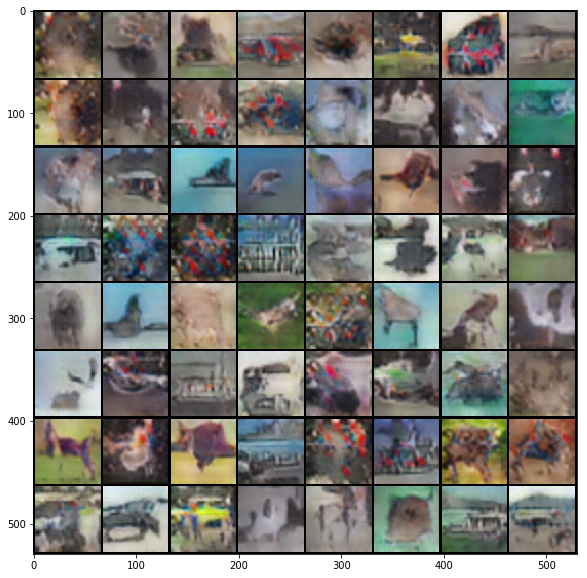

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

final_fake = mpimg.imread('datasets/fake_samples_epoch_024.png')
plt.figure(figsize=(10, 10))
plt.imshow(final_fake)

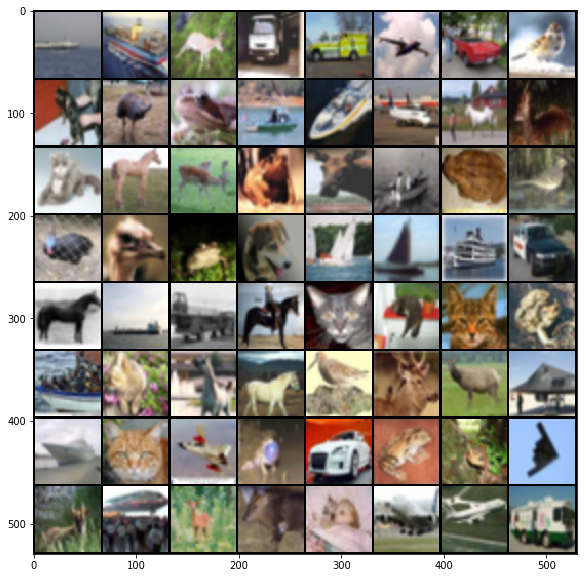

In [25]:
final_real = mpimg.imread('datasets/real_samples.png')
plt.figure(figsize=(10,10))
plt.imshow(final_real)